# Введение

Статистические методы обработки сигналов из области музыкальной акустики [Chauhan, 2020] оцениваем на применимость к задачам автоматического выделения (и не дай бог классификации) звуков морских млекопитающих. Задача выделения звуков морских обитателей является актуальной, о чем свидетельствуют свежии публикации в данной области [Ibrahim, 2018; Meridian, 2019; Kirsebom, 2020]. Конечно, эта задача могла бы решаться вручную, и так и делается на первых этапах[Watkins], однако далее, чтобы упростить жизнь операторов при  обработке больших объемов данных или чтобы создать автономный регистратор с экономией энергии и объема внутренней памяти, представлется интерес автоматизировать этот процесс [Kirsebom, 2020].

В данном блокноте мы используем данные [Kirsebom-data, 2015-19], содержащие реальные записи китов вида "North Atlantic right whale" ("Северный гладкий кит"), которые были любезно предоставлены всей научной общественности авторами исследования [Kirsebom, 2020].


> [Ibrahim,2018]https://doi.org/10.1121/1.5022281 ; <br>
> [Chauhan,2020]https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html ; <br>
> [Kirsebom-data,2015-19]https://doi.org/10.20383/101.0241 ; <br>
> [Kirsebom,2020]https://doi.org/10.1121/10.0001132 ; <br>
> [Watkins]https://cis.whoi.edu/science/B/whalesounds/about.cfm; <br>
> [Meridian,2019]https://meridian.cs.dal.ca/detecting-underwater-sounds-with-deep-learning/ ; <br>

In [1]:
import csv
import sklearn
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import warnings
import random
from tqdm.notebook import tqdm
from math import pi, cos
from typing import List, Dict, Tuple
from matplotlib import pyplot
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, 
                             precision_score, 
                             balanced_accuracy_score, 
                             f1_score, 
                             recall_score, 
                             accuracy_score, 
                             plot_roc_curve, 
                             roc_auc_score, 
                             roc_curve)

warnings.filterwarnings('ignore')

%matplotlib inline

SEED = 21
random.seed(SEED)
np.random.seed(SEED)

In [2]:
def getMetrics(Y_files_test, files_preds, output=True, threshold=0.5) -> Tuple:
    rms = np.sqrt(mean_squared_error(Y_files_test, files_preds))
    precision = precision_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    recall = recall_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    accuracy = accuracy_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    balanced_accuracy = balanced_accuracy_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    f1 = f1_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    f1_weighted = f1_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold), average = 'weighted')
    auc_roc = roc_auc_score(Y_files_test,  files_preds)
    if output:
        print(f"RMS: {rms}\n"
              f"Precision score: {precision}\n"
              f"Recall score: {recall}\n"
              f"Accuracy score: {accuracy}\n"
              f"Balanced accuracy score: {balanced_accuracy}\n"
              f"F1 score: {f1}\n"
              f"F1 weighted score: {f1_weighted}\n"
              f"AUC-ROC score: {auc_roc}")
    return (rms, precision, recall, accuracy, balanced_accuracy, f1, f1_weighted, auc_roc)

def readDataset(csvFilePath:str) -> (List, List):
    csv_file = csvFilePath
    files = []
    labels = []
    snr = []
    data_folder_name = csv_file[:csv_file.rfind('/')] + '/audio/'
    with open(csv_file) as csv_file_obj:
        rdr = csv.reader(csv_file_obj, delimiter=';')
        skip_first = True
        for row in rdr:
            if not skip_first:
                files.append(data_folder_name + row[0])
                labels.append(int(row[1]))
                snr.append(float(row[2]))
            skip_first = False
    return (files, labels)

In [18]:
files = []
labels = []
filesA, labelsA = readDataset('/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv')
files.extend(filesA)
labels.extend(labelsA)
print('Total files: ' + repr(len(files)))
print('Labeled \'1\': '+repr(np.sum(labels)))

Total files: 1767
Labeled '1': 744


In [5]:
my_file_num = np.flatnonzero(labels)[703]
display(my_file_num)

1623

In [5]:
x , sr = librosa.load('/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/A_1629.wav') # просто для примера

def trim_and_fade(x):
    "есть проблема с канадскими данными, так в начале и конце щелчек, который надо убирать"
    trim_in_out = 1000
    fade_in_out = 1000
    x = x[trim_in_out:-trim_in_out]
    x[:fade_in_out] = x[:fade_in_out] * np.array(range(0, fade_in_out))/fade_in_out
    x[-fade_in_out:] = x[-fade_in_out:] * (fade_in_out - 1 - np.array(range(0, fade_in_out)))/fade_in_out
    return x
x = trim_and_fade(x)
print('Sample rate: %0.3f s'  % sr)
print('Duration: %0.3f s'  % (x.shape[0] / sr))

Sample rate: 22050.000 s
Duration: 2.910 s


# Визуализируем признаки #

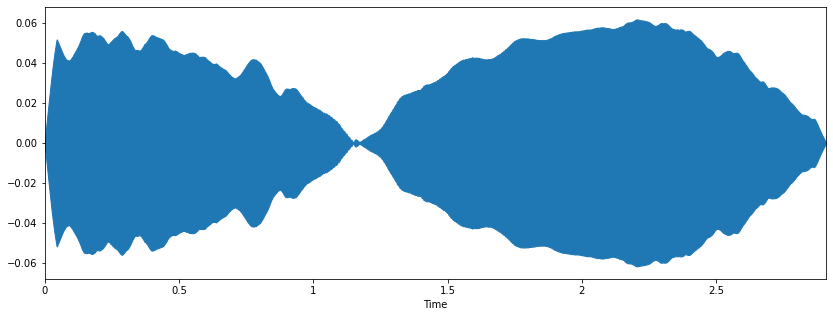

In [6]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

(0.0, 500.0)

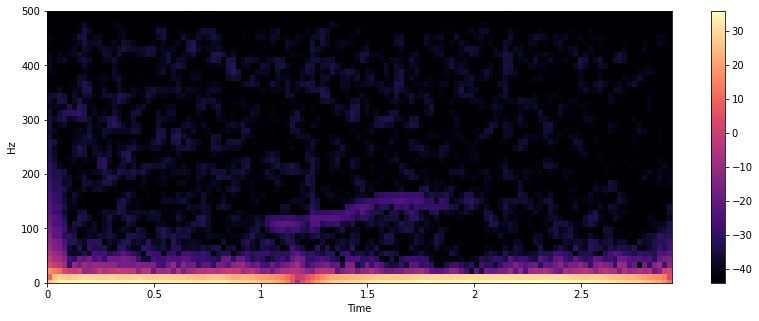

In [7]:
# всегда полезно смотреть спектрограмму! она содержит почи всю информацию! #
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.ylim((0, 500))

# Feature engineering

## 1. Spectral Centroid

Такая величина вычисляется следующим образом:  

$$SpectralCentroid=\frac{\sum_{k}f(k)S(k)}{\sum_{k}S(k)},$$

где $S(k)$ - спектральное значение в интервале $k$, $f(k)$ - частота (в Гц) звука на интервале $k$. Такую величину можно интерпретировать как "центр масс".

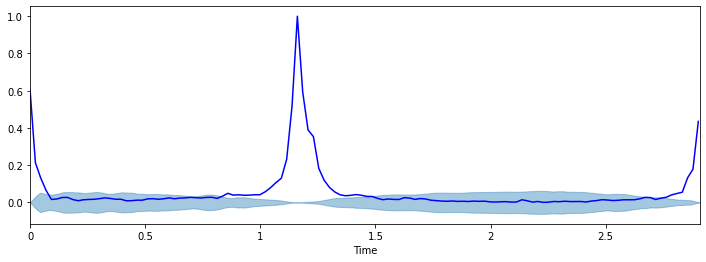

In [8]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

## 2. Spectral Rolloff ##
Представляет собо относительную частоту, в пределах которой сосредоточено 85% (по умолчанию) всей энергии спектра. 

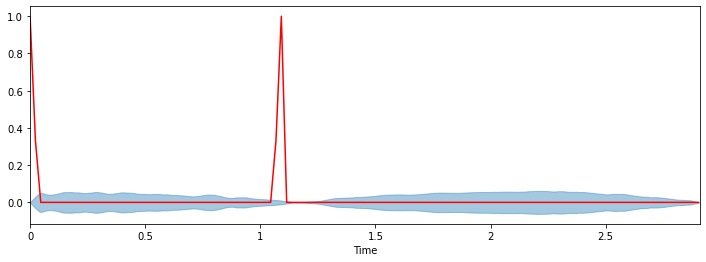

In [9]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

## 3. Spectral Bandwidth ##
Данную величину можно описать как разница между верхними и нижними частотами в непрерывной полосе частот.

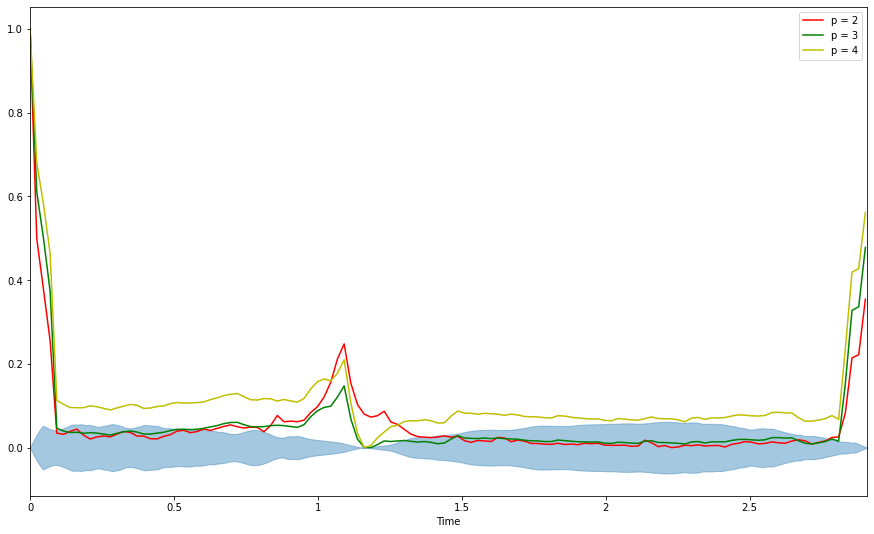

In [10]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

## 4. Zero-Crossing Rate ##

Количество пересечений нуля в сегменте сигнала.
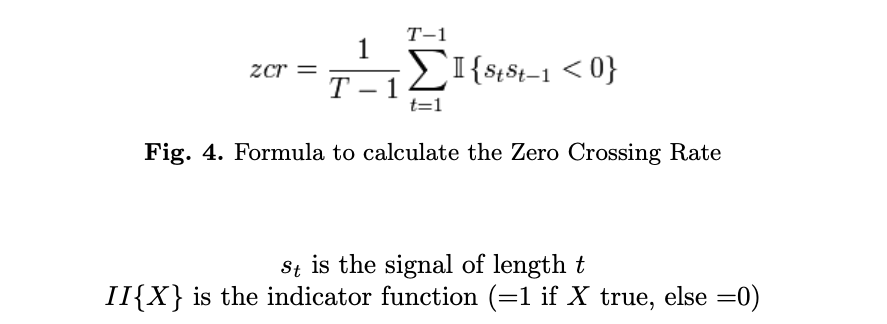

## 5. Mel-Frequency Cepstral Coefficients(MFCCs) ##

Это представление краткосрочного спектра мощности звука, основанное на линейном косинусном преобразовании логарифмического спектра мощности по нелинейной мел-шкале частоты.

(100, 126)


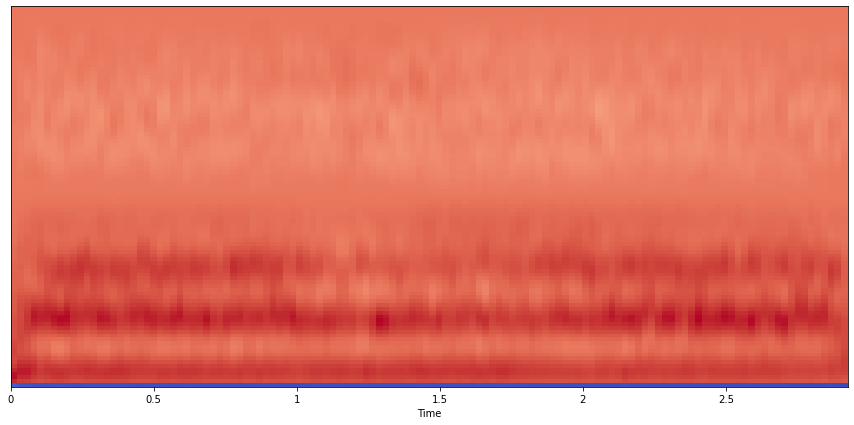

In [11]:
mfccs = librosa.feature.mfcc(x, sr=sr,  n_mfcc=100, lifter=50)
print(mfccs.shape)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## 6. Chroma feature ##
Является вектором признаков из 12 элементов, указывающий, сколько энергии каждого класса высоты тона {C, C#, D, D#, E, ..., B} присутствует в сигнале. Иными словами, он обеспечивает надежный способ описания меры сходства между разными аудиозаписями.

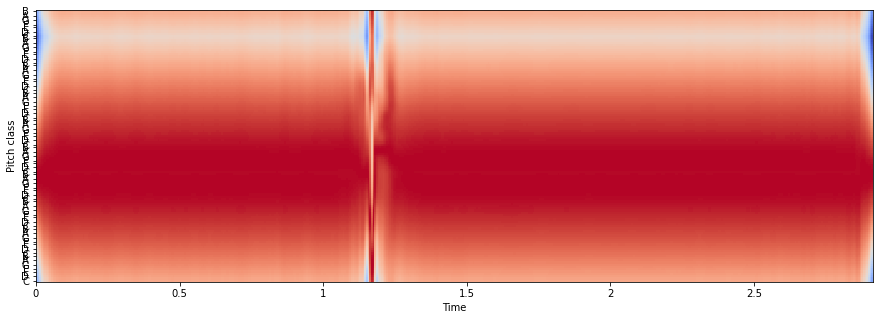

In [12]:
hop_length = 128
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length, n_chroma=120)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm', )

# Альтернативный набор признаков #
 посчитаем те же признаки, но:
* офильтруем сигнал в диапазоне кита до извлечения признаков,
* rms будет нормированный



In [13]:
import numpy as np
from math import pi, cos
freq_range = [80, 200]
improved_features_cached = [None, None]
def improved_features(wp, ws, full, sr, id):
    """
    Для вычисления этих признаков в функцию надо передавать начало и длнину окна
    и весь файл.
    """
    if improved_features_cached[0] != id:
        df = (1.0*sr)/len(full)
        nf11 = round(freq_range[0]/df * 0.9)
        nf12 = round(freq_range[0]/df * 1.1)
        nf21 = round(freq_range[1]/df * 0.9)
        nf22 = round(freq_range[1]/df * 1.1)
        
        yy = np.fft.fft(full)
        yy[:nf11] = 0
        yy[nf11:nf12] = yy[nf11:nf12] * np.array(
            [0.5 - 0.5 * cos((nf-nf11)*pi/(nf12-nf11))for nf in range(nf11, nf12)])
        yy[nf21:nf22] = yy[nf21:nf22] * np.array(
            [0.5 + 0.5 * cos((nf-nf21)*pi/(nf22-nf21))for nf in range(nf21, nf22)])
        yy[nf22:] = 0
        filtered = 2 * np.real( np.fft.ifft(yy) )
        improved_features_cached[:] = [id, filtered]
    else:
        filtered = improved_features_cached[1]
    fin = min(wp+ws, len(filtered))
    wx = filtered[wp:fin]
    rms_norm = np.std(wx) / np.std(filtered)
    spec_cent = librosa.feature.spectral_centroid(wx, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(wx, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(wx, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(wx)
    features = [rms_norm, np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)] 
    return features
improved_features_dict = {'f0':'rms_norm_band', 'f1': 'spec_cent_band', 'f2': 'spec_bw_band', 'f3':'rolloff_band', 'f4':'zcr_band'}

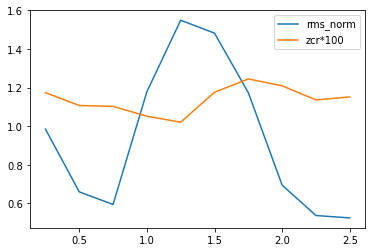

In [14]:
wpp = np.array([int(sr * 0.25 * n) for n in range(0,10)])
ws = int(0.5*sr)
res= np.ndarray((wpp.shape[0], 5))
for j in range(0, wpp.shape[0]):
    res_j = improved_features(wpp[j], ws, x, sr, -1)
    res[j,:] =res_j
tt = (wpp+ws*0.5) / (sr*1.0)
plt.plot(tt, res[:,0])
plt.plot(tt, res[:,4]*100)
plt.legend(('rms_norm', 'zcr*100'))
plt.show()

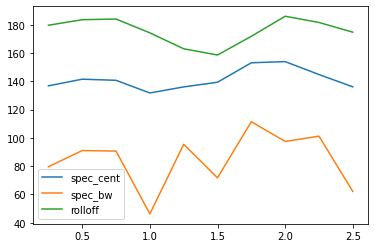

In [15]:
plt.plot(tt, res[:,1])
plt.plot(tt, res[:,2])
plt.plot(tt, res[:,3])
plt.legend(('spec_cent', 'spec_bw', 'rolloff'))
plt.show()

Графики выглядят более или менее осмысленно, особенно rms_norm.
Можно пробовать запихивать в классификатор. <br> Но мы пока этого делать не будем. Попробуем для лаконичности использовать библиотечные функии для фильтрации. <br>
Более того, сделаем нарезку в разных частотных диапазонах

In [16]:
from scipy import signal
from scipy.signal import butter, lfilter
import numpy as np
freq_range = [80, 200]
sos = signal.butter(5, [80, 200], 'bandpass', fs=sr, output='sos')

def improved_features_lib(_wx,sr):
    """
    Для вычисления этих признаков в функцию надо передавать начало и длнину окна
    и весь файл.
    """
    wx = signal.sosfilt(sos, _wx)
    rms = librosa.feature.rms(wx)
    spec_cent = librosa.feature.spectral_centroid(wx, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(wx, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(wx, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(wx)
    features = [np.mean(rms), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)] 
    return features

improved_features_dict = {'f0':'rms_norm_band', 'f1': 'spec_cent_band', 'f2': 'spec_bw_band', 'f3':'rolloff_band', 'f4':'zcr_band'}

In [19]:
from scipy import signal
from scipy.signal import butter, lfilter
import numpy as np
import librosa

x , sr = librosa.load( files[0])
ws = int(0.5*sr)   # (window size) увеличим размер окна в два раза
wd = int(ws * 0.25) # (window delta) сдвиг. соответственно оставим как раньше, поэтому уже берём четверть
wx = x[:ws] 

rms = librosa.feature.rms(wx)
chroma_stft = librosa.feature.chroma_stft(wx, sr=sr)
spec_cent = librosa.feature.spectral_centroid(wx, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(wx, sr=sr)
rolloff = librosa.feature.spectral_rolloff(wx, sr=sr)
zcr = librosa.feature.zero_crossing_rate(wx)
mfcc = librosa.feature.mfcc(wx, sr=sr)

features_dict = {'f0':'rms_mean', 'f1':'chroma_stft_mean', 'f2': 'spec_cent_mean', 'f3': 'spec_bw_mean', 'f4':'rolloff_mean', 'f5':'zcr_mean', 'f6': 'mfcc_mean'}
for i in range(len(rms[0])):
    features_dict[f'f{len(features_dict)}']=f'rms_{i}'
i = 0
for raw in chroma_stft:
    for j in range(len(raw)):
        features_dict[f'f{len(features_dict)}'] = f'chroma_stft_{i}'
        i = i + 1
for i in range(len(spec_cent[0])):
    features_dict[f'f{len(features_dict)}'] =f'spec_cent_{i}'
for i in range(len(spec_bw[0])):
    features_dict[f'f{len(features_dict)}'] = f'spec_bw_{i}'
for i in range(len(rolloff[0])):
    features_dict[ f'f{len(features_dict)}'] = f'rolloff_{i}'
for i in range(len(zcr[0])):
    features_dict[ f'f{len(features_dict)}'] = f'zcr_{i}' 
i = 0
for raw in mfcc:
    for j in range(len(raw)):
        features_dict[f'f{len(features_dict)}'] = f'mfcc_{i}' 
        i = i + 1 

sos = signal.butter(5, [80, 200], 'bandpass', fs=sr, output='sos')
def improved_features_lib2(_wx, sr):
    """
    Функция которая для окна выдаёт вектор признаков
    """
    wx = signal.sosfilt(sos, _wx)
    rms = librosa.feature.rms(wx)
    chroma_stft = librosa.feature.chroma_stft(wx, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(wx, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(wx, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(wx, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(wx)
    mfcc = librosa.feature.mfcc(wx, sr=sr)
    features = [np.mean(rms), np.mean(chroma_stft), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr), np.mean(mfcc)] 
    features.extend(rms[0])
    for i in chroma_stft:
        features.extend(i)
    features.extend(spec_cent[0]) 
    features.extend(spec_bw[0])
    features.extend(rolloff[0])
    features.extend(zcr[0])
    for i in mfcc:
        features.extend(i)
    return features

## Разворачиваем все признаки и нарезаем сигнал полосами  ##
Это работает не лучше, чем развернутые признаки в полосе 50-200Hz.
Поэтому это не используем

In [20]:
freq_ranges = []
begin_freq = 50
while begin_freq < sr:
    freq_ranges.append( (begin_freq, begin_freq*2) )
    begin_freq = begin_freq * 2
print(freq_ranges)
from scipy import signal
from scipy.signal import butter, lfilter
import numpy as np
soss = [] 
for freq_begin, freq_end in freq_ranges[:-2]:
    print(freq_begin)
    print(freq_end)
    soss.append (signal.butter(5, [freq_begin, freq_end], 'bandpass', fs=sr, output='sos') )
def improved_features_lib2_full_band(_wx, sr):
    """
    Функция которая для окна выдаёт вектор признаков
    """
    features = []
    for sos in soss:
        wx = signal.sosfilt(sos, _wx)
        rms = librosa.feature.rms(wx)
        chroma_stft = librosa.feature.chroma_stft(wx, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(wx, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(wx, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(wx, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(wx)
    mfcc = librosa.feature.mfcc(wx, sr=sr)
    features.extend([np.mean(rms), np.mean(chroma_stft), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr), np.mean(mfcc)] )
    features.extend(rms[0])
    for i in chroma_stft:
        features.extend(i)
    features.extend(spec_cent[0]) 
    features.extend(spec_bw[0])
    features.extend(rolloff[0])
    features.extend(zcr[0])
    for i in mfcc:
        features.extend(i)
    return features

[(50, 100), (100, 200), (200, 400), (400, 800), (800, 1600), (1600, 3200), (3200, 6400), (6400, 12800), (12800, 25600)]
50
100
100
200
200
400
400
800
800
1600
1600
3200
3200
6400


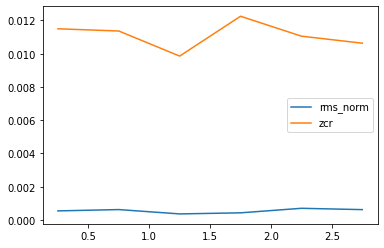

In [26]:
audio_data = files[my_file_num]
x , sr = librosa.load(audio_data)
ws = int(0.5*sr)
wp = 0
res = []
tt = []
while wp + ws < len(x):
    res_j = improved_features_lib(x[wp: wp+ws], sr)
    res.append(res_j)
    tt.append( (wp+ws*0.5) / (sr*1.0) )    
    wp = wp + ws 
plt.plot(tt, [r[0] for r in res ] )
plt.plot(tt, [r[4] for r in res ] )
plt.legend(('rms_norm', 'zcr'))
plt.show()

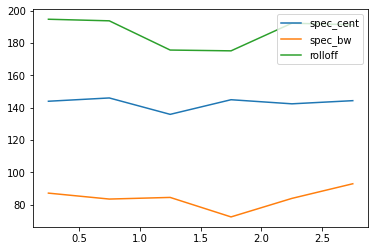

In [27]:
plt.plot(tt,  [r[1] for r in res ] )
plt.plot(tt,  [r[2] for r in res ] )
plt.plot(tt,  [r[3] for r in res ] )
plt.legend(('spec_cent', 'spec_bw', 'rolloff'))
plt.show()

# Построение обучающей выборки (X, Y) #
Признаки извлекать мы научились. Осталось пройти окном по аудиофайлам и создать обучающую выборку вида: <br>
$(X, Y )$, $X$ – матрица признаков, $Y$ – метки <br>
$ X = (x_1, x_2, .., x_i, ..., x_n),  |x_i| = \textit{number of features}$ <br>
$ Y = (y_1, y_2, ..., y_i, ..., y_n), y_i\in \{0, 1\} $
<br>
$ n = \frac{t_{len}} {\textit{window}_{size}}$ 


Но с канадскими данными есть проблема. В приложенным к ним файле разметки присваивается label=1 для всего файла целеиком, который имеет длину 3 с, а кит занимает там только некоторую часть. Беглый просмотр маленькой выборки файлов показал, что они нарезаны так, что сигнал кита примерно по центру, но смещается влево-вправо от файла к файлу, т.е. он может быть [0.9, 1.8], а может [1.4, 2.1], к примеру. Если для файла стоит label=1, то:
* на отметке 1.5 всегда есть кит,
* кит целиком заватывает интервал [1.4, 1.8] в 82% случаях,
* кит по-максиуму бывает в интервале [0.9, 2.2].

По этому для обучения решено отмечать окна:
* в интервале [1.4, 1.8] как $y_j=1$,
* вне интервала [0.9, 2.2] как $y_j=0$,
* в интервалах [0.9, 1.4] и [1.8, 2.2] не использовать для обучения

(Это справедливо для папки A и с учетом того, что я обрезаю 1000 отсчетов сначала файла)

Осталось пройтись окном по каждому файлу и разбить на окна


In [29]:
features_dict = {'f0': 'rms_mean', 
                 'f1': 'chroma_stft_mean', 
                 'f2': 'spec_cent_mean', 
                 'f3': 'spec_bw_mean', 
                 'f4': 'rolloff_mean', 
                 'f5': 'zcr_mean', 
                 'f6': 'mfcc_mean'}

In [30]:
audio_data = files[my_file_num]
x , sr = librosa.load(audio_data)
x = trim_and_fade(x)
wx = x[:ws] 

rms = librosa.feature.rms(wx)
chroma_stft = librosa.feature.chroma_stft(wx, sr=sr)
spec_cent = librosa.feature.spectral_centroid(wx, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(wx, sr=sr)
rolloff = librosa.feature.spectral_rolloff(wx, sr=sr)
zcr = librosa.feature.zero_crossing_rate(wx)
mfcc = librosa.feature.mfcc(wx, sr=sr)

features_dict = {}

for freq_begin, freq_end in freq_ranges[:-2]:
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_rms_mean'
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_chroma_stft_mean'
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_spec_cent_mean'
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_spec_bw_mean'
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_rolloff_mean'
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_zcr_mean'
    features_dict[f'f{len(features_dict)}']=f'{freq_begin}_{freq_end}_mfcc_mean'
    for i in range(len(rms[0])):
        features_dict[f'f{len(features_dict)}']=f'rms_{i}'
    i = 0
    for raw in chroma_stft:
        for j in range(len(raw)):
            features_dict[f'f{len(features_dict)}'] = f'chroma_stft_{i}'
            i = i + 1

    for i in range(len(spec_cent[0])):
        features_dict[f'f{len(features_dict)}'] =f'spec_cent_{i}'

    for i in range(len(spec_bw[0])):
        features_dict[f'f{len(features_dict)}'] = f'spec_bw_{i}'

    for i in range(len(rolloff[0])):
        features_dict[ f'f{len(features_dict)}'] = f'rolloff_{i}'

    for i in range(len(zcr[0])):
        features_dict[ f'f{len(features_dict)}'] = f'zcr_{i}' 

    i = 0
    for raw in mfcc:
        for j in range(len(raw)):
            features_dict[f'f{len(features_dict)}'] = f'mfcc_{i}' 
            i = i + 1 

# Извлечение признаков и формирование Train/Test #

In [31]:
from sklearn.model_selection import train_test_split
train_files, test_files, train_labels, test_labels  = train_test_split(files, labels, test_size=0.3, random_state=667) 

In [32]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.simplefilter("ignore")
good = [1.4, 1.8] # временной интервал, где точно находится кит (так делали для первого хорошего результата для A на A)
bad = [0.9, 2.2] # временной интервал, в котором точно нет кита

X_train = [] 
Y_train = []
X_test = []
Y_test = []

X_all = []
file_id_all=[]
for id, file in tqdm(enumerate(files), total=len(files)):
    x , sr = librosa.load(file)
    wp = 0  # (window position) начинаем бежать с самого начала, с 0 сэмпла
    while wp + ws < len(x):
        if labels[id] > 0:
            tc = (wp + ws*0.5) / sr
            if (tc < bad[0]) or (tc > bad[1]):
                into_signal = 0
            else:
                if (tc >= good[0]) and (tc <= good[1]):
                    into_signal = 1
                else:
                    wp = wp + wd   
                    continue
        else:
            into_signal = 0

        features = []
        wx = x[wp:wp+ws] # window x=
        features = improved_features_lib2(wx, sr)
        if file in train_files:
            X_train.append(features)
            Y_train.append(into_signal)
        else:
            X_test.append(features)
            Y_test.append(into_signal)
        wp = wp + wd

warnings.resetwarnings()

  0%|          | 0/1767 [00:00<?, ?it/s]

In [33]:
# посмотрем на размер обучающей выборки
len(X_train),len(X_train[1]), len(Y_train)

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(22337, 821, 22337)

Отлично! Обучающую выборку построили. Можно теперь её разделить на  train-test

In [34]:
# посмотрим насколько у нас не сбалансированные данные
# scale_pos_weight = total_negative_examples / total_positive_examples
(len(Y_train) - sum(Y_train)) / sum(Y_train)

13.40167633784655

In [35]:
# оценим accuracy для константного предсказателя 
(len(Y_train) - sum(Y_train)) / len(Y_train)

0.9305636388055692

Получилось, что негативных примеров, у нас сильно больше, чем позитивных.

In [36]:
import xgboost as xgb
model = xgb.XGBRegressor(objective ='binary:logistic',  n_estimators = 500, scale_pos_weight=9)

In [37]:
%%time
model.fit(np.array(X_train), np.array(Y_train), verbose=True )

[15:11:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 49min 35s, sys: 8.25 s, total: 49min 43s
Wall time: 2min 15s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=9, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [38]:
preds = model.predict(np.array(X_test))



---



In [39]:
xgb_metrics = getMetrics(Y_test, preds, 0.5)

RMS: 0.14788551810881448
Precision score: 0.8717948717948718
Recall score: 0.748898678414097
Accuracy score: 0.9742731646099142
Balanced accuracy score: 0.870226841740547
F1 score: 0.8056872037914692
F1 weighted score: 0.9733668899857361
AUC-ROC score: 0.9813281699402493


Constant negative: ROC AUC=0.500
Logistic: ROC AUC=0.981


/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


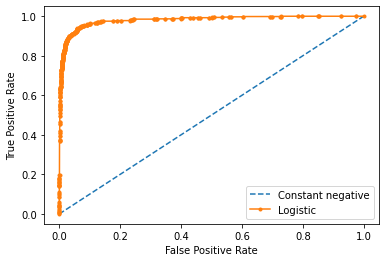

In [40]:
ns_probs = [0 for _ in range(len(Y_test))]
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, preds)
print('Constant negative: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, preds)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Constant negative')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

----

# Можно ли это как-то улучшить?

Попробуем также другие виды бустинга (LightGBM, CatBoost, бустинги из OneDAL) и методы подбора оптимальных гиперпараметров.

### Эксперимент 1

Подбор оптимальных гиперпараметров для XGBoost

In [169]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

xgb_model = xgb.XGBClassifier()

params = {
    "objective": ['binary:logistic'],
    "n_estimators": [200, 300, 400, 500, 600, 700, 750],
    "max_depth": [5, 10, 25, 50, 75],
    "booster": ["gbtree", "gblinear", "dart"],
    "learning_rate": [0.001, 0.01, 0.03],
    "nthread": [7],
    "scale_pos_weight": [1, 5, 9, 12],
    "verbosity": [1]
}

xgb_cv = RandomizedSearchCV(xgb_model, params, n_jobs=5, verbose=1, cv=5)

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [170]:
%%time
xgb_cv.fit(np.array(X_train), np.array(Y_train))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/latna/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:38:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 1h 12min 15s, sys: 41.9 s, total: 1h 12min 57s
Wall time: 4h 45min 45s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [171]:
xgb_cv.best_params_

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'verbosity': 1,
 'scale_pos_weight': 9,
 'objective': 'binary:logistic',
 'nthread': 7,
 'n_estimators': 600,
 'max_depth': 75,
 'learning_rate': 0.03,
 'booster': 'gbtree'}

In [172]:
xgb_cv.cv_results_

{'mean_fit_time': array([  761.86702151,  1338.29462404,  1490.44248047,   935.49303536,
           47.23285613,    58.26556563,    19.21541948,  1043.48154387,
           19.60936985, 10617.0765379 ]),
 'std_fit_time': array([ 15.52757117,  82.57713565,  85.43354055,  64.12449434,
          1.60755997,   1.35026721,   0.61653212,  12.79050077,
          0.82929481, 146.73481256]),
 'mean_score_time': array([ 0.07530909,  0.121034  ,  0.11612554,  0.0801147 ,  0.086762  ,
         0.07735229,  0.09208827,  0.0767962 ,  0.1072866 , 11.31507001]),
 'std_score_time': array([0.01423294, 0.01818427, 0.01377502, 0.0207376 , 0.00964529,
        0.00937828, 0.00976416, 0.00965498, 0.00954367, 5.54737404]),
 'param_verbosity': masked_array(data=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_scale_pos_weight': masked_array(data=[5, 12, 9, 1, 

In [173]:
xgb_predictions = xgb_cv.predict(np.array(X_test))

print("XGBoost Results:\n")
xgb_results = getMetrics(np.array(Y_test), xgb_predictions)

XGBoost Results:

rms: 0.174836
Precision score:  0.7876386687797148
Recall score:  0.756468797564688
Accuracy score:  0.9694323144104804
Balanced accuracy score:  0.8707575546801233
F1 score:  0.7717391304347826
F1 weighted score:  0.9691459302571838


### Эксперимент 2

Теперь попробуем LightGBM

In [134]:
import sys
!{sys.executable} -m pip install lightgbm

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
import lightgbm as lgbm
from sklearn.model_selection import RandomizedSearchCV

lgbm_model = lgbm.LGBMClassifier()

params = {
    "learning_rate": [0.001, 0.03, 0.01],
    "num_leaves": [30, 75, 100, 200, 250],
    "boosting_type" : ["gbdt", "dart", "goss", "rf"],
    "objective" : ["binary"],
    "max_depth" : [5, 10, 25, 50, 75, 100],
    "min_split_gain" : [0.01],
    "n_jobs": [5],
    "reg_alpha": [0.0, 0.5, 1.0],
    "reg_lambda": [0.0, 0.5, 1.0]
}

lgbm_cv = RandomizedSearchCV(lgbm_model, params, n_jobs=5, verbose=1, cv=5)

In [165]:
%%time
lgbm_cv.fit(np.array(X_train), np.array(Y_train))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/latna/.local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 1min 3s, sys: 0 ns, total: 1min 3s
Wall time: 4min 5s


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=5,
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss', 'rf'],
                                        'learning_rate': [0.001, 0.03, 0.01],
                                        'max_depth': [5, 10, 25, 50, 75, 100],
                                        'min_split_gain': [0.01], 'n_jobs': [5],
                                        'num_leaves': [30, 75, 100, 200, 250],
                                        'objective': ['binary'],
                                        'reg_alpha': [0.0, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.5, 1.0]},
                   verbose=1)

In [166]:
lgbm_cv.best_params_

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'reg_lambda': 1.0,
 'reg_alpha': 0.5,
 'objective': 'binary',
 'num_leaves': 30,
 'n_jobs': 5,
 'min_split_gain': 0.01,
 'max_depth': 50,
 'learning_rate': 0.03,
 'boosting_type': 'gbdt'}

In [167]:
lgbm_cv.cv_results_

{'mean_fit_time': array([25.60416827, 11.86336727, 28.85586834, 19.34462132, 19.71576204,
        10.03791084, 26.7460999 , 22.57521629, 30.19719429, 17.60580535]),
 'std_fit_time': array([3.00193041, 0.65952692, 3.52045847, 4.26026981, 6.73736406,
        1.02858384, 4.2442108 , 2.08679109, 5.26296901, 2.31801656]),
 'mean_score_time': array([0.04256244, 0.02794108, 0.04569664, 0.0290513 , 0.03503399,
        0.03879919, 0.04561501, 0.04100895, 0.0646112 , 0.02819357]),
 'std_score_time': array([0.01314015, 0.003998  , 0.01291395, 0.00448303, 0.00935446,
        0.01357283, 0.01077716, 0.01172403, 0.01236292, 0.0038122 ]),
 'param_reg_lambda': masked_array(data=[1.0, 1.0, 0.5, 1.0, 0.0, 0.0, 0.5, 1.0, 1.0, 1.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_reg_alpha': masked_array(data=[0.5, 0.5, 0.0, 0.5, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5],
              mask=[Fals

In [45]:
params = {'reg_lambda': 1.0,
          'reg_alpha': 0.5,
          'objective': 'binary',
          'num_leaves': 30,
          'min_split_gain': 0.01,
          'max_depth': 50,
          'learning_rate': 0.03,
          'boosting_type': 'gbdt'
}

lgbm_model = lgbm.LGBMClassifier(**params)

In [46]:
%%time
#Просто для замера времени обучения
lgbm_model.fit(np.array(X_train), np.array(Y_train))

CPU times: user 3min 28s, sys: 27.2 s, total: 3min 55s
Wall time: 36.9 s


LGBMClassifier(learning_rate=0.03, max_depth=50, min_split_gain=0.01,
               num_leaves=30, objective='binary', reg_alpha=0.5,
               reg_lambda=1.0)

In [48]:
from sklearn.metrics import roc_auc_score

lgbm_predictions = lgbm_model.predict(np.array(X_test))

print("LightGVM Results:\n")
lgbm_results = getMetrics(np.array(Y_test), lgbm_predictions)
print(f"AUC-ROC score: {roc_auc_score(np.array(Y_test), lgbm_predictions)}")

LightGVM Results:

rms: 0.177199
Precision score:  0.8317757009345794
Recall score:  0.6773211567732116
Accuracy score:  0.9686005406529424
Balanced accuracy score:  0.8336388174224276
F1 score:  0.7466442953020134
F1 weighted score:  0.9670998389275592
AUC-ROC score: 0.8336388174224276


### Эксперимент 3

Теперь попробуем CatBoost.

In [151]:
!{sys.executable} -m pip install catboost

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [183]:
import sys
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RandomizedSearchCV

catboost_model = CatBoostClassifier()

params = {
    "iterations": [5000],
    "learning_rate": [0.01, 0.03],
    "depth": [3, 6, 10]
}

catboost_cv = RandomizedSearchCV(catboost_model, params, n_jobs=5, verbose=1, cv=5)

In [184]:
%%time
catboost_cv.fit(np.array(X_train), np.array(Y_train), plot=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/latna/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/latna/.local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6747892	total: 61.3ms	remaining: 5m 6s
1:	learn: 0.6580237	total: 130ms	remaining: 5m 24s
2:	learn: 0.6425093	total: 195ms	remaining: 5m 24s
3:	learn: 0.6262441	total: 260ms	remaining: 5m 24s
4:	learn: 0.6108797	total: 327ms	remaining: 5m 27s
5:	learn: 0.5961734	total: 393ms	remaining: 5m 27s
6:	learn: 0.5806296	total: 459ms	remaining: 5m 27s
7:	learn: 0.5653186	total: 524ms	remaining: 5m 27s
8:	learn: 0.5500794	total: 595ms	remaining: 5m 29s
9:	learn: 0.5352245	total: 664ms	remaining: 5m 31s
10:	learn: 0.5226900	total: 728ms	remaining: 5m 30s
11:	learn: 0.5103509	total: 800ms	remaining: 5m 32s
12:	learn: 0.4971655	total: 866ms	remaining: 5m 32s
13:	learn: 0.4861383	total: 932ms	remaining: 5m 31s
14:	learn: 0.4747001	total: 997ms	remaining: 5m 31s
15:	learn: 0.4629636	total: 1.06s	remaining: 5m 31s
16:	learn: 0.4528447	total: 1.13s	remaining: 5m 31s
17:	learn: 0.4426375	total: 1.2s	remaining: 5m 31s
18:	learn: 0.4334866	total: 1.26s	remaining: 5m 31s
19:	learn: 0.4232300	to

160:	learn: 0.1024190	total: 10.9s	remaining: 5m 27s
161:	learn: 0.1020656	total: 11s	remaining: 5m 27s
162:	learn: 0.1017038	total: 11s	remaining: 5m 27s
163:	learn: 0.1013227	total: 11.1s	remaining: 5m 27s
164:	learn: 0.1010810	total: 11.2s	remaining: 5m 27s
165:	learn: 0.1007435	total: 11.2s	remaining: 5m 27s
166:	learn: 0.1004146	total: 11.3s	remaining: 5m 27s
167:	learn: 0.1001354	total: 11.4s	remaining: 5m 27s
168:	learn: 0.0998019	total: 11.4s	remaining: 5m 26s
169:	learn: 0.0995327	total: 11.5s	remaining: 5m 26s
170:	learn: 0.0992803	total: 11.6s	remaining: 5m 26s
171:	learn: 0.0989874	total: 11.6s	remaining: 5m 26s
172:	learn: 0.0987387	total: 11.7s	remaining: 5m 26s
173:	learn: 0.0984786	total: 11.8s	remaining: 5m 26s
174:	learn: 0.0981839	total: 11.8s	remaining: 5m 26s
175:	learn: 0.0979248	total: 11.9s	remaining: 5m 26s
176:	learn: 0.0976390	total: 12s	remaining: 5m 26s
177:	learn: 0.0973540	total: 12s	remaining: 5m 26s
178:	learn: 0.0970931	total: 12.1s	remaining: 5m 26s
1

318:	learn: 0.0763275	total: 21.6s	remaining: 5m 17s
319:	learn: 0.0762223	total: 21.7s	remaining: 5m 17s
320:	learn: 0.0761256	total: 21.8s	remaining: 5m 17s
321:	learn: 0.0760449	total: 21.8s	remaining: 5m 17s
322:	learn: 0.0759699	total: 21.9s	remaining: 5m 17s
323:	learn: 0.0758994	total: 22s	remaining: 5m 17s
324:	learn: 0.0758009	total: 22s	remaining: 5m 17s
325:	learn: 0.0757219	total: 22.1s	remaining: 5m 16s
326:	learn: 0.0756509	total: 22.2s	remaining: 5m 16s
327:	learn: 0.0755524	total: 22.2s	remaining: 5m 16s
328:	learn: 0.0754760	total: 22.3s	remaining: 5m 16s
329:	learn: 0.0753730	total: 22.4s	remaining: 5m 16s
330:	learn: 0.0752868	total: 22.4s	remaining: 5m 16s
331:	learn: 0.0751856	total: 22.5s	remaining: 5m 16s
332:	learn: 0.0750965	total: 22.6s	remaining: 5m 16s
333:	learn: 0.0750233	total: 22.6s	remaining: 5m 16s
334:	learn: 0.0749459	total: 22.7s	remaining: 5m 16s
335:	learn: 0.0748699	total: 22.8s	remaining: 5m 16s
336:	learn: 0.0747582	total: 22.9s	remaining: 5m 1

474:	learn: 0.0666595	total: 32.3s	remaining: 5m 7s
475:	learn: 0.0665986	total: 32.4s	remaining: 5m 7s
476:	learn: 0.0665477	total: 32.5s	remaining: 5m 7s
477:	learn: 0.0665100	total: 32.5s	remaining: 5m 7s
478:	learn: 0.0664601	total: 32.6s	remaining: 5m 7s
479:	learn: 0.0663634	total: 32.7s	remaining: 5m 7s
480:	learn: 0.0663111	total: 32.7s	remaining: 5m 7s
481:	learn: 0.0662552	total: 32.8s	remaining: 5m 7s
482:	learn: 0.0662152	total: 32.9s	remaining: 5m 7s
483:	learn: 0.0661605	total: 33s	remaining: 5m 7s
484:	learn: 0.0661184	total: 33.1s	remaining: 5m 7s
485:	learn: 0.0660739	total: 33.1s	remaining: 5m 7s
486:	learn: 0.0660232	total: 33.2s	remaining: 5m 7s
487:	learn: 0.0659647	total: 33.3s	remaining: 5m 7s
488:	learn: 0.0659089	total: 33.4s	remaining: 5m 7s
489:	learn: 0.0658486	total: 33.4s	remaining: 5m 7s
490:	learn: 0.0657966	total: 33.5s	remaining: 5m 7s
491:	learn: 0.0657512	total: 33.6s	remaining: 5m 7s
492:	learn: 0.0657034	total: 33.7s	remaining: 5m 7s
493:	learn: 0.

633:	learn: 0.0597524	total: 44.7s	remaining: 5m 7s
634:	learn: 0.0597213	total: 44.8s	remaining: 5m 7s
635:	learn: 0.0596925	total: 44.9s	remaining: 5m 7s
636:	learn: 0.0596618	total: 44.9s	remaining: 5m 7s
637:	learn: 0.0596348	total: 45s	remaining: 5m 7s
638:	learn: 0.0596017	total: 45.1s	remaining: 5m 7s
639:	learn: 0.0595585	total: 45.2s	remaining: 5m 7s
640:	learn: 0.0595144	total: 45.2s	remaining: 5m 7s
641:	learn: 0.0594739	total: 45.3s	remaining: 5m 7s
642:	learn: 0.0594306	total: 45.4s	remaining: 5m 7s
643:	learn: 0.0593977	total: 45.5s	remaining: 5m 7s
644:	learn: 0.0593498	total: 45.6s	remaining: 5m 7s
645:	learn: 0.0592986	total: 45.6s	remaining: 5m 7s
646:	learn: 0.0592657	total: 45.7s	remaining: 5m 7s
647:	learn: 0.0592201	total: 45.8s	remaining: 5m 7s
648:	learn: 0.0591909	total: 45.9s	remaining: 5m 7s
649:	learn: 0.0591497	total: 45.9s	remaining: 5m 7s
650:	learn: 0.0591026	total: 46s	remaining: 5m 7s
651:	learn: 0.0590683	total: 46.1s	remaining: 5m 7s
652:	learn: 0.05

792:	learn: 0.0539894	total: 57.1s	remaining: 5m 2s
793:	learn: 0.0539518	total: 57.2s	remaining: 5m 2s
794:	learn: 0.0539257	total: 57.3s	remaining: 5m 2s
795:	learn: 0.0538797	total: 57.3s	remaining: 5m 2s
796:	learn: 0.0538451	total: 57.4s	remaining: 5m 2s
797:	learn: 0.0537914	total: 57.5s	remaining: 5m 2s
798:	learn: 0.0537610	total: 57.6s	remaining: 5m 2s
799:	learn: 0.0537445	total: 57.6s	remaining: 5m 2s
800:	learn: 0.0537260	total: 57.7s	remaining: 5m 2s
801:	learn: 0.0536960	total: 57.8s	remaining: 5m 2s
802:	learn: 0.0536681	total: 57.9s	remaining: 5m 2s
803:	learn: 0.0536335	total: 58s	remaining: 5m 2s
804:	learn: 0.0536050	total: 58s	remaining: 5m 2s
805:	learn: 0.0535783	total: 58.1s	remaining: 5m 2s
806:	learn: 0.0535444	total: 58.2s	remaining: 5m 2s
807:	learn: 0.0535106	total: 58.3s	remaining: 5m 2s
808:	learn: 0.0534868	total: 58.4s	remaining: 5m 2s
809:	learn: 0.0534452	total: 58.5s	remaining: 5m 2s
810:	learn: 0.0534074	total: 58.5s	remaining: 5m 2s
811:	learn: 0.05

951:	learn: 0.0492845	total: 1m 9s	remaining: 4m 54s
952:	learn: 0.0492501	total: 1m 9s	remaining: 4m 54s
953:	learn: 0.0492055	total: 1m 9s	remaining: 4m 54s
954:	learn: 0.0491719	total: 1m 9s	remaining: 4m 54s
955:	learn: 0.0491419	total: 1m 9s	remaining: 4m 54s
956:	learn: 0.0491188	total: 1m 9s	remaining: 4m 54s
957:	learn: 0.0490954	total: 1m 9s	remaining: 4m 54s
958:	learn: 0.0490635	total: 1m 9s	remaining: 4m 54s
959:	learn: 0.0490436	total: 1m 9s	remaining: 4m 54s
960:	learn: 0.0490290	total: 1m 10s	remaining: 4m 54s
961:	learn: 0.0489989	total: 1m 10s	remaining: 4m 54s
962:	learn: 0.0489579	total: 1m 10s	remaining: 4m 54s
963:	learn: 0.0489373	total: 1m 10s	remaining: 4m 54s
964:	learn: 0.0489237	total: 1m 10s	remaining: 4m 54s
965:	learn: 0.0489007	total: 1m 10s	remaining: 4m 54s
966:	learn: 0.0488819	total: 1m 10s	remaining: 4m 54s
967:	learn: 0.0488511	total: 1m 10s	remaining: 4m 54s
968:	learn: 0.0488215	total: 1m 10s	remaining: 4m 54s
969:	learn: 0.0488060	total: 1m 10s	r

1102:	learn: 0.0452043	total: 1m 21s	remaining: 4m 48s
1103:	learn: 0.0451865	total: 1m 21s	remaining: 4m 48s
1104:	learn: 0.0451598	total: 1m 21s	remaining: 4m 48s
1105:	learn: 0.0451309	total: 1m 21s	remaining: 4m 48s
1106:	learn: 0.0451220	total: 1m 22s	remaining: 4m 48s
1107:	learn: 0.0450972	total: 1m 22s	remaining: 4m 48s
1108:	learn: 0.0450722	total: 1m 22s	remaining: 4m 48s
1109:	learn: 0.0450644	total: 1m 22s	remaining: 4m 48s
1110:	learn: 0.0450416	total: 1m 22s	remaining: 4m 48s
1111:	learn: 0.0450231	total: 1m 22s	remaining: 4m 48s
1112:	learn: 0.0449957	total: 1m 22s	remaining: 4m 48s
1113:	learn: 0.0449689	total: 1m 22s	remaining: 4m 48s
1114:	learn: 0.0449371	total: 1m 22s	remaining: 4m 47s
1115:	learn: 0.0449267	total: 1m 22s	remaining: 4m 47s
1116:	learn: 0.0448931	total: 1m 22s	remaining: 4m 47s
1117:	learn: 0.0448642	total: 1m 22s	remaining: 4m 47s
1118:	learn: 0.0448456	total: 1m 22s	remaining: 4m 47s
1119:	learn: 0.0448333	total: 1m 23s	remaining: 4m 47s
1120:	lear

1252:	learn: 0.0415951	total: 1m 33s	remaining: 4m 38s
1253:	learn: 0.0415685	total: 1m 33s	remaining: 4m 38s
1254:	learn: 0.0415583	total: 1m 33s	remaining: 4m 38s
1255:	learn: 0.0415491	total: 1m 33s	remaining: 4m 38s
1256:	learn: 0.0415246	total: 1m 33s	remaining: 4m 38s
1257:	learn: 0.0414916	total: 1m 33s	remaining: 4m 38s
1258:	learn: 0.0414605	total: 1m 33s	remaining: 4m 38s
1259:	learn: 0.0414392	total: 1m 33s	remaining: 4m 38s
1260:	learn: 0.0414007	total: 1m 33s	remaining: 4m 38s
1261:	learn: 0.0413654	total: 1m 33s	remaining: 4m 37s
1262:	learn: 0.0413516	total: 1m 33s	remaining: 4m 37s
1263:	learn: 0.0413384	total: 1m 34s	remaining: 4m 37s
1264:	learn: 0.0413284	total: 1m 34s	remaining: 4m 37s
1265:	learn: 0.0413014	total: 1m 34s	remaining: 4m 37s
1266:	learn: 0.0412673	total: 1m 34s	remaining: 4m 37s
1267:	learn: 0.0412407	total: 1m 34s	remaining: 4m 37s
1268:	learn: 0.0412129	total: 1m 34s	remaining: 4m 37s
1269:	learn: 0.0411884	total: 1m 34s	remaining: 4m 37s
1270:	lear

1402:	learn: 0.0383934	total: 1m 44s	remaining: 4m 28s
1403:	learn: 0.0383783	total: 1m 44s	remaining: 4m 28s
1404:	learn: 0.0383754	total: 1m 44s	remaining: 4m 28s
1405:	learn: 0.0383558	total: 1m 44s	remaining: 4m 28s
1406:	learn: 0.0383392	total: 1m 44s	remaining: 4m 28s
1407:	learn: 0.0383157	total: 1m 45s	remaining: 4m 27s
1408:	learn: 0.0383042	total: 1m 45s	remaining: 4m 27s
1409:	learn: 0.0382707	total: 1m 45s	remaining: 4m 27s
1410:	learn: 0.0382509	total: 1m 45s	remaining: 4m 27s
1411:	learn: 0.0382339	total: 1m 45s	remaining: 4m 27s
1412:	learn: 0.0382095	total: 1m 45s	remaining: 4m 27s
1413:	learn: 0.0381715	total: 1m 45s	remaining: 4m 28s
1414:	learn: 0.0381606	total: 1m 46s	remaining: 4m 28s
1415:	learn: 0.0381554	total: 1m 46s	remaining: 4m 28s
1416:	learn: 0.0381271	total: 1m 46s	remaining: 4m 28s
1417:	learn: 0.0381217	total: 1m 46s	remaining: 4m 28s
1418:	learn: 0.0381094	total: 1m 46s	remaining: 4m 28s
1419:	learn: 0.0380733	total: 1m 46s	remaining: 4m 28s
1420:	lear

1551:	learn: 0.0355895	total: 1m 56s	remaining: 4m 18s
1552:	learn: 0.0355759	total: 1m 56s	remaining: 4m 18s
1553:	learn: 0.0355516	total: 1m 56s	remaining: 4m 18s
1554:	learn: 0.0355473	total: 1m 56s	remaining: 4m 18s
1555:	learn: 0.0355415	total: 1m 56s	remaining: 4m 18s
1556:	learn: 0.0355289	total: 1m 56s	remaining: 4m 18s
1557:	learn: 0.0355101	total: 1m 56s	remaining: 4m 18s
1558:	learn: 0.0354942	total: 1m 56s	remaining: 4m 18s
1559:	learn: 0.0354837	total: 1m 57s	remaining: 4m 18s
1560:	learn: 0.0354738	total: 1m 57s	remaining: 4m 17s
1561:	learn: 0.0354504	total: 1m 57s	remaining: 4m 17s
1562:	learn: 0.0354330	total: 1m 57s	remaining: 4m 17s
1563:	learn: 0.0354062	total: 1m 57s	remaining: 4m 17s
1564:	learn: 0.0353852	total: 1m 57s	remaining: 4m 17s
1565:	learn: 0.0353722	total: 1m 57s	remaining: 4m 17s
1566:	learn: 0.0353454	total: 1m 57s	remaining: 4m 17s
1567:	learn: 0.0353238	total: 1m 57s	remaining: 4m 17s
1568:	learn: 0.0353016	total: 1m 57s	remaining: 4m 17s
1569:	lear

1703:	learn: 0.0331474	total: 2m 8s	remaining: 4m 8s
1704:	learn: 0.0331325	total: 2m 8s	remaining: 4m 8s
1705:	learn: 0.0331132	total: 2m 8s	remaining: 4m 8s
1706:	learn: 0.0331000	total: 2m 8s	remaining: 4m 8s
1707:	learn: 0.0330920	total: 2m 8s	remaining: 4m 8s
1708:	learn: 0.0330722	total: 2m 8s	remaining: 4m 8s
1709:	learn: 0.0330586	total: 2m 8s	remaining: 4m 8s
1710:	learn: 0.0330429	total: 2m 9s	remaining: 4m 8s
1711:	learn: 0.0330275	total: 2m 9s	remaining: 4m 7s
1712:	learn: 0.0330073	total: 2m 9s	remaining: 4m 7s
1713:	learn: 0.0329976	total: 2m 9s	remaining: 4m 7s
1714:	learn: 0.0329860	total: 2m 9s	remaining: 4m 7s
1715:	learn: 0.0329750	total: 2m 9s	remaining: 4m 7s
1716:	learn: 0.0329716	total: 2m 9s	remaining: 4m 7s
1717:	learn: 0.0329612	total: 2m 9s	remaining: 4m 7s
1718:	learn: 0.0329458	total: 2m 9s	remaining: 4m 7s
1719:	learn: 0.0329248	total: 2m 9s	remaining: 4m 7s
1720:	learn: 0.0329097	total: 2m 9s	remaining: 4m 7s
1721:	learn: 0.0329004	total: 2m 9s	remaining:

1856:	learn: 0.0308210	total: 2m 20s	remaining: 3m 57s
1857:	learn: 0.0308149	total: 2m 20s	remaining: 3m 57s
1858:	learn: 0.0307929	total: 2m 20s	remaining: 3m 57s
1859:	learn: 0.0307845	total: 2m 20s	remaining: 3m 57s
1860:	learn: 0.0307766	total: 2m 20s	remaining: 3m 57s
1861:	learn: 0.0307613	total: 2m 20s	remaining: 3m 56s
1862:	learn: 0.0307424	total: 2m 20s	remaining: 3m 56s
1863:	learn: 0.0307302	total: 2m 20s	remaining: 3m 56s
1864:	learn: 0.0306993	total: 2m 20s	remaining: 3m 56s
1865:	learn: 0.0306967	total: 2m 20s	remaining: 3m 56s
1866:	learn: 0.0306774	total: 2m 20s	remaining: 3m 56s
1867:	learn: 0.0306605	total: 2m 21s	remaining: 3m 56s
1868:	learn: 0.0306405	total: 2m 21s	remaining: 3m 56s
1869:	learn: 0.0306216	total: 2m 21s	remaining: 3m 56s
1870:	learn: 0.0306083	total: 2m 21s	remaining: 3m 56s
1871:	learn: 0.0305931	total: 2m 21s	remaining: 3m 56s
1872:	learn: 0.0305776	total: 2m 21s	remaining: 3m 56s
1873:	learn: 0.0305683	total: 2m 21s	remaining: 3m 56s
1874:	lear

2005:	learn: 0.0288125	total: 2m 32s	remaining: 3m 47s
2006:	learn: 0.0288090	total: 2m 32s	remaining: 3m 47s
2007:	learn: 0.0288020	total: 2m 32s	remaining: 3m 47s
2008:	learn: 0.0287918	total: 2m 32s	remaining: 3m 46s
2009:	learn: 0.0287733	total: 2m 32s	remaining: 3m 46s
2010:	learn: 0.0287569	total: 2m 32s	remaining: 3m 46s
2011:	learn: 0.0287354	total: 2m 32s	remaining: 3m 46s
2012:	learn: 0.0287332	total: 2m 32s	remaining: 3m 46s
2013:	learn: 0.0287215	total: 2m 32s	remaining: 3m 46s
2014:	learn: 0.0287081	total: 2m 32s	remaining: 3m 46s
2015:	learn: 0.0286910	total: 2m 33s	remaining: 3m 46s
2016:	learn: 0.0286806	total: 2m 33s	remaining: 3m 46s
2017:	learn: 0.0286745	total: 2m 33s	remaining: 3m 46s
2018:	learn: 0.0286717	total: 2m 33s	remaining: 3m 46s
2019:	learn: 0.0286575	total: 2m 33s	remaining: 3m 46s
2020:	learn: 0.0286403	total: 2m 33s	remaining: 3m 46s
2021:	learn: 0.0286225	total: 2m 33s	remaining: 3m 46s
2022:	learn: 0.0286023	total: 2m 33s	remaining: 3m 45s
2023:	lear

2154:	learn: 0.0270559	total: 2m 44s	remaining: 3m 36s
2155:	learn: 0.0270516	total: 2m 44s	remaining: 3m 36s
2156:	learn: 0.0270376	total: 2m 44s	remaining: 3m 36s
2157:	learn: 0.0270224	total: 2m 44s	remaining: 3m 36s
2158:	learn: 0.0270101	total: 2m 44s	remaining: 3m 36s
2159:	learn: 0.0269920	total: 2m 44s	remaining: 3m 36s
2160:	learn: 0.0269759	total: 2m 44s	remaining: 3m 36s
2161:	learn: 0.0269687	total: 2m 44s	remaining: 3m 36s
2162:	learn: 0.0269611	total: 2m 44s	remaining: 3m 36s
2163:	learn: 0.0269470	total: 2m 44s	remaining: 3m 36s
2164:	learn: 0.0269372	total: 2m 44s	remaining: 3m 36s
2165:	learn: 0.0269163	total: 2m 45s	remaining: 3m 35s
2166:	learn: 0.0268980	total: 2m 45s	remaining: 3m 35s
2167:	learn: 0.0268915	total: 2m 45s	remaining: 3m 35s
2168:	learn: 0.0268721	total: 2m 45s	remaining: 3m 35s
2169:	learn: 0.0268554	total: 2m 45s	remaining: 3m 35s
2170:	learn: 0.0268411	total: 2m 45s	remaining: 3m 35s
2171:	learn: 0.0268284	total: 2m 45s	remaining: 3m 35s
2172:	lear

2305:	learn: 0.0253438	total: 2m 56s	remaining: 3m 26s
2306:	learn: 0.0253316	total: 2m 56s	remaining: 3m 25s
2307:	learn: 0.0253199	total: 2m 56s	remaining: 3m 25s
2308:	learn: 0.0253142	total: 2m 56s	remaining: 3m 25s
2309:	learn: 0.0252978	total: 2m 56s	remaining: 3m 25s
2310:	learn: 0.0252861	total: 2m 56s	remaining: 3m 25s
2311:	learn: 0.0252751	total: 2m 56s	remaining: 3m 25s
2312:	learn: 0.0252662	total: 2m 56s	remaining: 3m 25s
2313:	learn: 0.0252526	total: 2m 56s	remaining: 3m 25s
2314:	learn: 0.0252505	total: 2m 57s	remaining: 3m 25s
2315:	learn: 0.0252424	total: 2m 57s	remaining: 3m 25s
2316:	learn: 0.0252359	total: 2m 57s	remaining: 3m 25s
2317:	learn: 0.0252179	total: 2m 57s	remaining: 3m 25s
2318:	learn: 0.0252097	total: 2m 57s	remaining: 3m 25s
2319:	learn: 0.0251907	total: 2m 57s	remaining: 3m 25s
2320:	learn: 0.0251764	total: 2m 57s	remaining: 3m 24s
2321:	learn: 0.0251693	total: 2m 57s	remaining: 3m 24s
2322:	learn: 0.0251570	total: 2m 57s	remaining: 3m 24s
2323:	lear

2459:	learn: 0.0238446	total: 3m 8s	remaining: 3m 14s
2460:	learn: 0.0238421	total: 3m 8s	remaining: 3m 14s
2461:	learn: 0.0238240	total: 3m 8s	remaining: 3m 14s
2462:	learn: 0.0238128	total: 3m 8s	remaining: 3m 14s
2463:	learn: 0.0238038	total: 3m 8s	remaining: 3m 14s
2464:	learn: 0.0237949	total: 3m 9s	remaining: 3m 14s
2465:	learn: 0.0237857	total: 3m 9s	remaining: 3m 14s
2466:	learn: 0.0237770	total: 3m 9s	remaining: 3m 14s
2467:	learn: 0.0237625	total: 3m 9s	remaining: 3m 14s
2468:	learn: 0.0237491	total: 3m 9s	remaining: 3m 14s
2469:	learn: 0.0237446	total: 3m 9s	remaining: 3m 14s
2470:	learn: 0.0237348	total: 3m 9s	remaining: 3m 13s
2471:	learn: 0.0237286	total: 3m 9s	remaining: 3m 13s
2472:	learn: 0.0237095	total: 3m 9s	remaining: 3m 13s
2473:	learn: 0.0237004	total: 3m 9s	remaining: 3m 13s
2474:	learn: 0.0236843	total: 3m 9s	remaining: 3m 13s
2475:	learn: 0.0236701	total: 3m 9s	remaining: 3m 13s
2476:	learn: 0.0236608	total: 3m 10s	remaining: 3m 13s
2477:	learn: 0.0236507	tota

2610:	learn: 0.0224405	total: 3m 21s	remaining: 3m 4s
2611:	learn: 0.0224325	total: 3m 21s	remaining: 3m 4s
2612:	learn: 0.0224186	total: 3m 21s	remaining: 3m 4s
2613:	learn: 0.0224085	total: 3m 21s	remaining: 3m 3s
2614:	learn: 0.0224002	total: 3m 21s	remaining: 3m 3s
2615:	learn: 0.0223930	total: 3m 21s	remaining: 3m 3s
2616:	learn: 0.0223860	total: 3m 21s	remaining: 3m 3s
2617:	learn: 0.0223765	total: 3m 21s	remaining: 3m 3s
2618:	learn: 0.0223717	total: 3m 21s	remaining: 3m 3s
2619:	learn: 0.0223617	total: 3m 21s	remaining: 3m 3s
2620:	learn: 0.0223596	total: 3m 22s	remaining: 3m 3s
2621:	learn: 0.0223467	total: 3m 22s	remaining: 3m 3s
2622:	learn: 0.0223390	total: 3m 22s	remaining: 3m 3s
2623:	learn: 0.0223327	total: 3m 22s	remaining: 3m 3s
2624:	learn: 0.0223248	total: 3m 22s	remaining: 3m 3s
2625:	learn: 0.0223152	total: 3m 22s	remaining: 3m 3s
2626:	learn: 0.0223070	total: 3m 22s	remaining: 3m 2s
2627:	learn: 0.0222951	total: 3m 22s	remaining: 3m 2s
2628:	learn: 0.0222892	total

2762:	learn: 0.0211262	total: 3m 33s	remaining: 2m 53s
2763:	learn: 0.0211197	total: 3m 33s	remaining: 2m 52s
2764:	learn: 0.0211108	total: 3m 33s	remaining: 2m 52s
2765:	learn: 0.0211003	total: 3m 33s	remaining: 2m 52s
2766:	learn: 0.0210887	total: 3m 34s	remaining: 2m 52s
2767:	learn: 0.0210798	total: 3m 34s	remaining: 2m 52s
2768:	learn: 0.0210708	total: 3m 34s	remaining: 2m 52s
2769:	learn: 0.0210642	total: 3m 34s	remaining: 2m 52s
2770:	learn: 0.0210626	total: 3m 34s	remaining: 2m 52s
2771:	learn: 0.0210486	total: 3m 34s	remaining: 2m 52s
2772:	learn: 0.0210427	total: 3m 34s	remaining: 2m 52s
2773:	learn: 0.0210361	total: 3m 34s	remaining: 2m 52s
2774:	learn: 0.0210342	total: 3m 34s	remaining: 2m 52s
2775:	learn: 0.0210285	total: 3m 34s	remaining: 2m 51s
2776:	learn: 0.0210194	total: 3m 34s	remaining: 2m 51s
2777:	learn: 0.0210112	total: 3m 34s	remaining: 2m 51s
2778:	learn: 0.0210029	total: 3m 34s	remaining: 2m 51s
2779:	learn: 0.0209944	total: 3m 35s	remaining: 2m 51s
2780:	lear

2913:	learn: 0.0198942	total: 3m 45s	remaining: 2m 41s
2914:	learn: 0.0198862	total: 3m 46s	remaining: 2m 41s
2915:	learn: 0.0198733	total: 3m 46s	remaining: 2m 41s
2916:	learn: 0.0198632	total: 3m 46s	remaining: 2m 41s
2917:	learn: 0.0198589	total: 3m 46s	remaining: 2m 41s
2918:	learn: 0.0198522	total: 3m 46s	remaining: 2m 41s
2919:	learn: 0.0198463	total: 3m 46s	remaining: 2m 41s
2920:	learn: 0.0198412	total: 3m 46s	remaining: 2m 41s
2921:	learn: 0.0198374	total: 3m 46s	remaining: 2m 41s
2922:	learn: 0.0198359	total: 3m 46s	remaining: 2m 41s
2923:	learn: 0.0198303	total: 3m 46s	remaining: 2m 40s
2924:	learn: 0.0198217	total: 3m 46s	remaining: 2m 40s
2925:	learn: 0.0198138	total: 3m 46s	remaining: 2m 40s
2926:	learn: 0.0198112	total: 3m 46s	remaining: 2m 40s
2927:	learn: 0.0197995	total: 3m 47s	remaining: 2m 40s
2928:	learn: 0.0197916	total: 3m 47s	remaining: 2m 40s
2929:	learn: 0.0197874	total: 3m 47s	remaining: 2m 40s
2930:	learn: 0.0197848	total: 3m 47s	remaining: 2m 40s
2931:	lear

3064:	learn: 0.0187231	total: 3m 58s	remaining: 2m 30s
3065:	learn: 0.0187162	total: 3m 58s	remaining: 2m 30s
3066:	learn: 0.0187059	total: 3m 58s	remaining: 2m 30s
3067:	learn: 0.0187002	total: 3m 58s	remaining: 2m 30s
3068:	learn: 0.0186935	total: 3m 58s	remaining: 2m 30s
3069:	learn: 0.0186845	total: 3m 58s	remaining: 2m 30s
3070:	learn: 0.0186822	total: 3m 59s	remaining: 2m 30s
3071:	learn: 0.0186788	total: 3m 59s	remaining: 2m 30s
3072:	learn: 0.0186706	total: 3m 59s	remaining: 2m 30s
3073:	learn: 0.0186675	total: 3m 59s	remaining: 2m 29s
3074:	learn: 0.0186619	total: 3m 59s	remaining: 2m 29s
3075:	learn: 0.0186498	total: 3m 59s	remaining: 2m 29s
3076:	learn: 0.0186422	total: 3m 59s	remaining: 2m 29s
3077:	learn: 0.0186322	total: 3m 59s	remaining: 2m 29s
3078:	learn: 0.0186270	total: 3m 59s	remaining: 2m 29s
3079:	learn: 0.0186128	total: 3m 59s	remaining: 2m 29s
3080:	learn: 0.0186091	total: 3m 59s	remaining: 2m 29s
3081:	learn: 0.0186016	total: 3m 59s	remaining: 2m 29s
3082:	lear

3218:	learn: 0.0176827	total: 4m 11s	remaining: 2m 18s
3219:	learn: 0.0176749	total: 4m 11s	remaining: 2m 18s
3220:	learn: 0.0176625	total: 4m 11s	remaining: 2m 18s
3221:	learn: 0.0176484	total: 4m 11s	remaining: 2m 18s
3222:	learn: 0.0176440	total: 4m 11s	remaining: 2m 18s
3223:	learn: 0.0176405	total: 4m 11s	remaining: 2m 18s
3224:	learn: 0.0176319	total: 4m 11s	remaining: 2m 18s
3225:	learn: 0.0176266	total: 4m 11s	remaining: 2m 18s
3226:	learn: 0.0176190	total: 4m 11s	remaining: 2m 18s
3227:	learn: 0.0176058	total: 4m 11s	remaining: 2m 18s
3228:	learn: 0.0175954	total: 4m 11s	remaining: 2m 18s
3229:	learn: 0.0175826	total: 4m 12s	remaining: 2m 18s
3230:	learn: 0.0175770	total: 4m 12s	remaining: 2m 18s
3231:	learn: 0.0175656	total: 4m 12s	remaining: 2m 17s
3232:	learn: 0.0175624	total: 4m 12s	remaining: 2m 17s
3233:	learn: 0.0175588	total: 4m 12s	remaining: 2m 17s
3234:	learn: 0.0175570	total: 4m 12s	remaining: 2m 17s
3235:	learn: 0.0175488	total: 4m 12s	remaining: 2m 17s
3236:	lear

3369:	learn: 0.0166548	total: 4m 23s	remaining: 2m 7s
3370:	learn: 0.0166464	total: 4m 23s	remaining: 2m 7s
3371:	learn: 0.0166404	total: 4m 24s	remaining: 2m 7s
3372:	learn: 0.0166363	total: 4m 24s	remaining: 2m 7s
3373:	learn: 0.0166303	total: 4m 24s	remaining: 2m 7s
3374:	learn: 0.0166274	total: 4m 24s	remaining: 2m 7s
3375:	learn: 0.0166245	total: 4m 24s	remaining: 2m 7s
3376:	learn: 0.0166212	total: 4m 24s	remaining: 2m 7s
3377:	learn: 0.0166126	total: 4m 24s	remaining: 2m 6s
3378:	learn: 0.0166070	total: 4m 24s	remaining: 2m 6s
3379:	learn: 0.0166006	total: 4m 24s	remaining: 2m 6s
3380:	learn: 0.0165933	total: 4m 24s	remaining: 2m 6s
3381:	learn: 0.0165858	total: 4m 24s	remaining: 2m 6s
3382:	learn: 0.0165802	total: 4m 24s	remaining: 2m 6s
3383:	learn: 0.0165759	total: 4m 24s	remaining: 2m 6s
3384:	learn: 0.0165684	total: 4m 25s	remaining: 2m 6s
3385:	learn: 0.0165542	total: 4m 25s	remaining: 2m 6s
3386:	learn: 0.0165481	total: 4m 25s	remaining: 2m 6s
3387:	learn: 0.0165377	total

3523:	learn: 0.0156776	total: 4m 36s	remaining: 1m 55s
3524:	learn: 0.0156688	total: 4m 36s	remaining: 1m 55s
3525:	learn: 0.0156628	total: 4m 36s	remaining: 1m 55s
3526:	learn: 0.0156588	total: 4m 36s	remaining: 1m 55s
3527:	learn: 0.0156531	total: 4m 36s	remaining: 1m 55s
3528:	learn: 0.0156422	total: 4m 37s	remaining: 1m 55s
3529:	learn: 0.0156398	total: 4m 37s	remaining: 1m 55s
3530:	learn: 0.0156327	total: 4m 37s	remaining: 1m 55s
3531:	learn: 0.0156294	total: 4m 37s	remaining: 1m 55s
3532:	learn: 0.0156230	total: 4m 37s	remaining: 1m 55s
3533:	learn: 0.0156159	total: 4m 38s	remaining: 1m 55s
3534:	learn: 0.0156128	total: 4m 38s	remaining: 1m 55s
3535:	learn: 0.0156052	total: 4m 38s	remaining: 1m 55s
3536:	learn: 0.0155972	total: 4m 38s	remaining: 1m 55s
3537:	learn: 0.0155853	total: 4m 38s	remaining: 1m 55s
3538:	learn: 0.0155766	total: 4m 38s	remaining: 1m 54s
3539:	learn: 0.0155684	total: 4m 38s	remaining: 1m 54s
3540:	learn: 0.0155620	total: 4m 38s	remaining: 1m 54s
3541:	lear

3673:	learn: 0.0148043	total: 4m 49s	remaining: 1m 44s
3674:	learn: 0.0147951	total: 4m 49s	remaining: 1m 44s
3675:	learn: 0.0147914	total: 4m 49s	remaining: 1m 44s
3676:	learn: 0.0147889	total: 4m 49s	remaining: 1m 44s
3677:	learn: 0.0147842	total: 4m 49s	remaining: 1m 44s
3678:	learn: 0.0147828	total: 4m 49s	remaining: 1m 43s
3679:	learn: 0.0147782	total: 4m 49s	remaining: 1m 43s
3680:	learn: 0.0147715	total: 4m 49s	remaining: 1m 43s
3681:	learn: 0.0147652	total: 4m 49s	remaining: 1m 43s
3682:	learn: 0.0147608	total: 4m 49s	remaining: 1m 43s
3683:	learn: 0.0147558	total: 4m 50s	remaining: 1m 43s
3684:	learn: 0.0147527	total: 4m 50s	remaining: 1m 43s
3685:	learn: 0.0147412	total: 4m 50s	remaining: 1m 43s
3686:	learn: 0.0147315	total: 4m 50s	remaining: 1m 43s
3687:	learn: 0.0147253	total: 4m 50s	remaining: 1m 43s
3688:	learn: 0.0147210	total: 4m 50s	remaining: 1m 43s
3689:	learn: 0.0147128	total: 4m 50s	remaining: 1m 43s
3690:	learn: 0.0147058	total: 4m 51s	remaining: 1m 43s
3691:	lear

3825:	learn: 0.0140186	total: 5m 2s	remaining: 1m 32s
3826:	learn: 0.0140111	total: 5m 2s	remaining: 1m 32s
3827:	learn: 0.0140010	total: 5m 2s	remaining: 1m 32s
3828:	learn: 0.0139962	total: 5m 2s	remaining: 1m 32s
3829:	learn: 0.0139888	total: 5m 2s	remaining: 1m 32s
3830:	learn: 0.0139864	total: 5m 2s	remaining: 1m 32s
3831:	learn: 0.0139776	total: 5m 2s	remaining: 1m 32s
3832:	learn: 0.0139743	total: 5m 2s	remaining: 1m 32s
3833:	learn: 0.0139727	total: 5m 3s	remaining: 1m 32s
3834:	learn: 0.0139654	total: 5m 3s	remaining: 1m 32s
3835:	learn: 0.0139571	total: 5m 3s	remaining: 1m 31s
3836:	learn: 0.0139519	total: 5m 3s	remaining: 1m 31s
3837:	learn: 0.0139438	total: 5m 3s	remaining: 1m 31s
3838:	learn: 0.0139389	total: 5m 3s	remaining: 1m 31s
3839:	learn: 0.0139317	total: 5m 3s	remaining: 1m 31s
3840:	learn: 0.0139255	total: 5m 3s	remaining: 1m 31s
3841:	learn: 0.0139148	total: 5m 3s	remaining: 1m 31s
3842:	learn: 0.0139115	total: 5m 3s	remaining: 1m 31s
3843:	learn: 0.0139061	total

3976:	learn: 0.0132699	total: 5m 15s	remaining: 1m 21s
3977:	learn: 0.0132678	total: 5m 15s	remaining: 1m 21s
3978:	learn: 0.0132636	total: 5m 15s	remaining: 1m 21s
3979:	learn: 0.0132619	total: 5m 15s	remaining: 1m 20s
3980:	learn: 0.0132559	total: 5m 16s	remaining: 1m 20s
3981:	learn: 0.0132530	total: 5m 16s	remaining: 1m 20s
3982:	learn: 0.0132510	total: 5m 16s	remaining: 1m 20s
3983:	learn: 0.0132411	total: 5m 16s	remaining: 1m 20s
3984:	learn: 0.0132346	total: 5m 16s	remaining: 1m 20s
3985:	learn: 0.0132259	total: 5m 16s	remaining: 1m 20s
3986:	learn: 0.0132198	total: 5m 16s	remaining: 1m 20s
3987:	learn: 0.0132117	total: 5m 16s	remaining: 1m 20s
3988:	learn: 0.0132075	total: 5m 16s	remaining: 1m 20s
3989:	learn: 0.0132049	total: 5m 16s	remaining: 1m 20s
3990:	learn: 0.0131968	total: 5m 16s	remaining: 1m 20s
3991:	learn: 0.0131873	total: 5m 16s	remaining: 1m 20s
3992:	learn: 0.0131856	total: 5m 16s	remaining: 1m 19s
3993:	learn: 0.0131813	total: 5m 17s	remaining: 1m 19s
3994:	lear

4128:	learn: 0.0125802	total: 5m 28s	remaining: 1m 9s
4129:	learn: 0.0125729	total: 5m 28s	remaining: 1m 9s
4130:	learn: 0.0125692	total: 5m 28s	remaining: 1m 9s
4131:	learn: 0.0125636	total: 5m 29s	remaining: 1m 9s
4132:	learn: 0.0125629	total: 5m 29s	remaining: 1m 9s
4133:	learn: 0.0125568	total: 5m 29s	remaining: 1m 8s
4134:	learn: 0.0125497	total: 5m 29s	remaining: 1m 8s
4135:	learn: 0.0125467	total: 5m 29s	remaining: 1m 8s
4136:	learn: 0.0125382	total: 5m 29s	remaining: 1m 8s
4137:	learn: 0.0125352	total: 5m 29s	remaining: 1m 8s
4138:	learn: 0.0125312	total: 5m 29s	remaining: 1m 8s
4139:	learn: 0.0125266	total: 5m 29s	remaining: 1m 8s
4140:	learn: 0.0125182	total: 5m 29s	remaining: 1m 8s
4141:	learn: 0.0125108	total: 5m 29s	remaining: 1m 8s
4142:	learn: 0.0125083	total: 5m 29s	remaining: 1m 8s
4143:	learn: 0.0125077	total: 5m 29s	remaining: 1m 8s
4144:	learn: 0.0125021	total: 5m 30s	remaining: 1m 8s
4145:	learn: 0.0125000	total: 5m 30s	remaining: 1m 8s
4146:	learn: 0.0124981	total

4281:	learn: 0.0118883	total: 5m 41s	remaining: 57.3s
4282:	learn: 0.0118863	total: 5m 41s	remaining: 57.2s
4283:	learn: 0.0118787	total: 5m 42s	remaining: 57.2s
4284:	learn: 0.0118749	total: 5m 42s	remaining: 57.1s
4285:	learn: 0.0118726	total: 5m 42s	remaining: 57s
4286:	learn: 0.0118707	total: 5m 42s	remaining: 56.9s
4287:	learn: 0.0118638	total: 5m 42s	remaining: 56.8s
4288:	learn: 0.0118609	total: 5m 42s	remaining: 56.8s
4289:	learn: 0.0118569	total: 5m 42s	remaining: 56.7s
4290:	learn: 0.0118549	total: 5m 42s	remaining: 56.6s
4291:	learn: 0.0118515	total: 5m 42s	remaining: 56.5s
4292:	learn: 0.0118448	total: 5m 42s	remaining: 56.4s
4293:	learn: 0.0118408	total: 5m 42s	remaining: 56.4s
4294:	learn: 0.0118357	total: 5m 42s	remaining: 56.3s
4295:	learn: 0.0118342	total: 5m 42s	remaining: 56.2s
4296:	learn: 0.0118277	total: 5m 43s	remaining: 56.1s
4297:	learn: 0.0118209	total: 5m 43s	remaining: 56s
4298:	learn: 0.0118122	total: 5m 43s	remaining: 56s
4299:	learn: 0.0118088	total: 5m 4

4436:	learn: 0.0112309	total: 5m 54s	remaining: 44.9s
4437:	learn: 0.0112293	total: 5m 54s	remaining: 44.9s
4438:	learn: 0.0112256	total: 5m 54s	remaining: 44.8s
4439:	learn: 0.0112231	total: 5m 54s	remaining: 44.7s
4440:	learn: 0.0112197	total: 5m 54s	remaining: 44.6s
4441:	learn: 0.0112167	total: 5m 54s	remaining: 44.5s
4442:	learn: 0.0112148	total: 5m 54s	remaining: 44.5s
4443:	learn: 0.0112116	total: 5m 54s	remaining: 44.4s
4444:	learn: 0.0112093	total: 5m 54s	remaining: 44.3s
4445:	learn: 0.0112078	total: 5m 54s	remaining: 44.2s
4446:	learn: 0.0112049	total: 5m 54s	remaining: 44.1s
4447:	learn: 0.0112027	total: 5m 54s	remaining: 44s
4448:	learn: 0.0111989	total: 5m 55s	remaining: 44s
4449:	learn: 0.0111976	total: 5m 55s	remaining: 43.9s
4450:	learn: 0.0111915	total: 5m 55s	remaining: 43.8s
4451:	learn: 0.0111875	total: 5m 55s	remaining: 43.7s
4452:	learn: 0.0111804	total: 5m 55s	remaining: 43.7s
4453:	learn: 0.0111789	total: 5m 55s	remaining: 43.6s
4454:	learn: 0.0111741	total: 5m

4593:	learn: 0.0106114	total: 6m 6s	remaining: 32.4s
4594:	learn: 0.0106069	total: 6m 6s	remaining: 32.3s
4595:	learn: 0.0106046	total: 6m 6s	remaining: 32.3s
4596:	learn: 0.0105992	total: 6m 6s	remaining: 32.2s
4597:	learn: 0.0105940	total: 6m 7s	remaining: 32.1s
4598:	learn: 0.0105933	total: 6m 7s	remaining: 32s
4599:	learn: 0.0105910	total: 6m 7s	remaining: 31.9s
4600:	learn: 0.0105890	total: 6m 7s	remaining: 31.8s
4601:	learn: 0.0105868	total: 6m 7s	remaining: 31.8s
4602:	learn: 0.0105846	total: 6m 7s	remaining: 31.7s
4603:	learn: 0.0105831	total: 6m 7s	remaining: 31.6s
4604:	learn: 0.0105793	total: 6m 7s	remaining: 31.5s
4605:	learn: 0.0105716	total: 6m 7s	remaining: 31.4s
4606:	learn: 0.0105662	total: 6m 7s	remaining: 31.4s
4607:	learn: 0.0105600	total: 6m 7s	remaining: 31.3s
4608:	learn: 0.0105585	total: 6m 7s	remaining: 31.2s
4609:	learn: 0.0105504	total: 6m 7s	remaining: 31.1s
4610:	learn: 0.0105437	total: 6m 8s	remaining: 31s
4611:	learn: 0.0105391	total: 6m 8s	remaining: 31s

4747:	learn: 0.0100080	total: 6m 19s	remaining: 20.2s
4748:	learn: 0.0100034	total: 6m 19s	remaining: 20.1s
4749:	learn: 0.0099966	total: 6m 19s	remaining: 20s
4750:	learn: 0.0099915	total: 6m 20s	remaining: 19.9s
4751:	learn: 0.0099890	total: 6m 20s	remaining: 19.8s
4752:	learn: 0.0099868	total: 6m 20s	remaining: 19.8s
4753:	learn: 0.0099835	total: 6m 20s	remaining: 19.7s
4754:	learn: 0.0099789	total: 6m 20s	remaining: 19.6s
4755:	learn: 0.0099756	total: 6m 20s	remaining: 19.5s
4756:	learn: 0.0099739	total: 6m 20s	remaining: 19.4s
4757:	learn: 0.0099685	total: 6m 20s	remaining: 19.4s
4758:	learn: 0.0099643	total: 6m 20s	remaining: 19.3s
4759:	learn: 0.0099573	total: 6m 20s	remaining: 19.2s
4760:	learn: 0.0099564	total: 6m 20s	remaining: 19.1s
4761:	learn: 0.0099537	total: 6m 20s	remaining: 19s
4762:	learn: 0.0099503	total: 6m 20s	remaining: 18.9s
4763:	learn: 0.0099489	total: 6m 20s	remaining: 18.9s
4764:	learn: 0.0099469	total: 6m 20s	remaining: 18.8s
4765:	learn: 0.0099428	total: 6m

4901:	learn: 0.0094822	total: 6m 32s	remaining: 7.84s
4902:	learn: 0.0094771	total: 6m 32s	remaining: 7.76s
4903:	learn: 0.0094755	total: 6m 32s	remaining: 7.68s
4904:	learn: 0.0094749	total: 6m 32s	remaining: 7.6s
4905:	learn: 0.0094689	total: 6m 32s	remaining: 7.52s
4906:	learn: 0.0094680	total: 6m 32s	remaining: 7.44s
4907:	learn: 0.0094608	total: 6m 32s	remaining: 7.36s
4908:	learn: 0.0094583	total: 6m 32s	remaining: 7.28s
4909:	learn: 0.0094533	total: 6m 32s	remaining: 7.2s
4910:	learn: 0.0094489	total: 6m 32s	remaining: 7.12s
4911:	learn: 0.0094439	total: 6m 32s	remaining: 7.04s
4912:	learn: 0.0094435	total: 6m 32s	remaining: 6.96s
4913:	learn: 0.0094417	total: 6m 33s	remaining: 6.88s
4914:	learn: 0.0094370	total: 6m 33s	remaining: 6.8s
4915:	learn: 0.0094350	total: 6m 33s	remaining: 6.72s
4916:	learn: 0.0094293	total: 6m 33s	remaining: 6.64s
4917:	learn: 0.0094244	total: 6m 33s	remaining: 6.56s
4918:	learn: 0.0094233	total: 6m 33s	remaining: 6.48s
4919:	learn: 0.0094202	total: 6

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fca6c724a90>,
                   n_jobs=5,
                   param_distributions={'depth': [3, 6, 10],
                                        'iterations': [5000],
                                        'learning_rate': [0.01, 0.03]},
                   verbose=1)

In [185]:
catboost_cv.best_params_

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'learning_rate': 0.01, 'iterations': 5000, 'depth': 6}

In [186]:
catboost_cv.cv_results_

{'mean_fit_time': array([  411.95557704,   406.82707825,  1602.40655942,  1729.90410681,
        20496.78615174, 20246.17933125]),
 'std_fit_time': array([  15.46902646,   27.06935249,   75.76278066,  116.28016343,
        1536.33812976,  590.26340151]),
 'mean_score_time': array([2.09207935, 2.38285084, 3.49049649, 5.64901295, 5.77091522,
        4.4464047 ]),
 'std_score_time': array([0.23143872, 0.21320188, 0.0856332 , 1.61235413, 1.49757351,
        2.64517743]),
 'param_learning_rate': masked_array(data=[0.01, 0.03, 0.01, 0.03, 0.01, 0.03],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_iterations': masked_array(data=[5000, 5000, 5000, 5000, 5000, 5000],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_depth': masked_array(data=[3, 3, 6, 6, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?'

In [187]:
catboost_predictions = catboost_cv.predict(np.array(X_test))

print("CatBoost Results:\n")
catboost_results = getMetrics(np.array(Y_test), catboost_predictions)

CatBoost Results:

rms: 0.170927
Precision score:  0.8186440677966101
Recall score:  0.7351598173515982
Accuracy score:  0.9707839467664795
Balanced accuracy score:  0.8616095928628318
F1 score:  0.7746591820368885
F1 weighted score:  0.97005348041277


In [193]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(np.array(Y_test), catboost_predictions))

0.8616095928628319


/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
#Просто для замера скорости обучения
from catboost import CatBoostClassifier

params = {'learning_rate': 0.01, 'iterations': 5000, 'depth': 6}

catboost_model = CatBoostClassifier(**params)

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
%%time
catboost_model.fit(np.array(X_train), np.array(Y_train), verbose=False)

CPU times: user 2h 25s, sys: 2min 39s, total: 2h 3min 4s
Wall time: 6min 24s


In [54]:
from sklearn.metrics import roc_auc_score

catboost_predictions = catboost_model.predict(np.array(X_test))

print("CatBoost Results:\n")
catboost_results = getMetrics(np.array(Y_test), catboost_predictions)
print(f"AUC-ROC score: {roc_auc_score(np.array(Y_test), catboost_predictions)}")

CatBoost Results:

rms: 0.170927
Precision score:  0.8186440677966101
Recall score:  0.7351598173515982
Accuracy score:  0.9707839467664795
Balanced accuracy score:  0.8616095928628318
F1 score:  0.7746591820368885
F1 weighted score:  0.97005348041277
AUC-ROC score: 0.8616095928628319


### Эксперимент 4

Воспользуемся библиотекой OneDAL (часть OneAPI от Intel). В ней есть несколько видов бустинга и других алгоритмов, которые могут дать неплохие результаты в текущей задаче. 

Для начала возьмём Gradient Boosted Tree

In [131]:
import daal4py as d4p

def gbt_classification_hyperparameter_bruteforce(numClasses: int, maxIterations: list, maxTreeDepth: list, 
                                                 shrinkage: list, observationsPerTreeFraction, target_metric: str, 
                                                 verbose: bool, progress: int):
    best_target_metric_value = 0
    best_maxIterations = 0
    best_max_tree_depth = 0
    best_shrinkage = 0
    best_observations_per_tree_fraction = 0
    number_of_iteration = 1
    
    for maxIt in maxIterations:
        for depth in maxTreeDepth:
            for cur_shrinkage in shrinkage:
                for observation in observationsPerTreeFraction:
                    gbt_classification_model = d4p.gbt_classification_training(numClasses, 
                                                                               maxIterations=maxIt, 
                                                                               maxTreeDepth=depth, 
                                                                               shrinkage=cur_shrinkage, 
                                                                               observationsPerTreeFraction=observation)
                    
                    gbt_classification_train_res = gbt_classification_model.compute(np.array(X_train), 
                                                                                    np.array(Y_train).reshape(-1, 1))
                    gbt_classification_model_test = d4p.gbt_classification_prediction(numClasses)
                    gbt_classification_predict_result = gbt_classification_model_test.compute(np.array(X_test),
                                                                                              gbt_classification_train_res.model)
                    if verbose:
                        print(f"{number_of_iteration}) Results for maxIterations = {maxIt}, "
                              f"maxTreeDepth = {depth}, shrinkage = {cur_shrinkage}, observationsPerTreeFraction = {observation}\n")
                    metrics = getMetrics(Y_test, gbt_classification_predict_result.prediction, output=verbose)
                    if verbose:
                        print()
                    current_target_metric_value = 0
                    if target_metric == "precision":
                        current_target_metric_value = metrics[1]
                    elif target_metric == "recall":
                        current_target_metric_value = metrics[2]
                    elif target_metric == "accuracy":
                        current_target_metric_value = metrics[3]
                    elif target_metric == "balanced-accuracy":
                        current_target_metric_value = metrics[4]
                    elif target_metric == "f1":
                        current_target_metric_value = metrics[5]
                    elif target_metric == "f1-weighted":
                        current_target_metric_value = metrics[6]
                    elif target_metric == "auc-roc" or target_metric == "roc-auc":
                        current_target_metric_value = metrics[7]
                    if current_target_metric_value > best_target_metric_value:
                        best_maxIterations = maxIt
                        best_max_tree_depth = depth
                        best_target_metric_value = current_target_metric_value
                        best_shrinkage = cur_shrinkage
                        best_observations_per_tree_fraction = observation
                    if progress and not number_of_iteration % progress:
                        print(f"{number_of_iteration}/{len(maxIterations)*len(maxTreeDepth)*len(shrinkage)*len(observationsPerTreeFraction)}"
                              f" iterations completed\n")
                    number_of_iteration += 1
                        
                
    print(f"Best {target_metric}: {best_target_metric_value}\nParams: maxIterations = {best_maxIterations}, "
          f"maxTreeDepth = {best_max_tree_depth}, shrinkage = {best_shrinkage}, "
          f"observationsPerTreeFraction = {best_observations_per_tree_fraction}")
    return (best_target_metric_value, best_maxIterations, best_max_tree_depth, best_shrinkage, best_observations_per_tree_fraction)

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
%%time
dal_gbt_params = gbt_classification_hyperparameter_bruteforce(numClasses=2, 
                                                              maxIterations=[25, 50, 75, 100, 150, 200, 250], 
                                                              maxTreeDepth=[3, 5, 8, 10, 15], 
                                                              shrinkage=[0.1, 0.3, 0.5, 0.7, 0.9],
                                                              observationsPerTreeFraction=[0.2, 0.4, 0.6, 0.8], 
                                                              target_metric="auc-roc", 
                                                              verbose=False,
                                                              progress=10)

10/700 iterations completed

20/700 iterations completed

30/700 iterations completed

40/700 iterations completed

50/700 iterations completed

60/700 iterations completed

70/700 iterations completed

80/700 iterations completed

90/700 iterations completed

100/700 iterations completed

110/700 iterations completed

120/700 iterations completed

130/700 iterations completed

140/700 iterations completed

150/700 iterations completed

160/700 iterations completed

170/700 iterations completed

180/700 iterations completed

190/700 iterations completed

200/700 iterations completed

210/700 iterations completed

220/700 iterations completed

230/700 iterations completed

240/700 iterations completed

250/700 iterations completed

260/700 iterations completed

270/700 iterations completed

280/700 iterations completed

290/700 iterations completed

300/700 iterations completed

310/700 iterations completed

320/700 iterations completed

330/700 iterations completed

340/700 iterations 

In [71]:
dal_gbt_params

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.8721524882812838, 200, 3, 0.1, 0.8)

In [72]:
dal_gbt_model = d4p.gbt_classification_training(2, 
                                                maxIterations=dal_gbt_params[1], 
                                                maxTreeDepth=dal_gbt_params[2], 
                                                shrinkage=dal_gbt_params[3], 
                                                observationsPerTreeFraction=dal_gbt_params[4])

In [73]:
%%time
dal_gbt_fitted = dal_gbt_model.compute(np.array(X_train), np.array(Y_train).reshape(-1, 1))

CPU times: user 4min 45s, sys: 3.4 s, total: 4min 49s
Wall time: 39.4 s


In [74]:
dal_gbt_test_model = d4p.gbt_classification_prediction(2)

dal_gbt_predictions = dal_gbt_test_model.compute(np.array(X_test), dal_gbt_fitted.model)

print("OneDAL Gradient Boosted Tree Results:\n")
dal_gbt_results = getMetrics(np.array(Y_test), dal_gbt_predictions.prediction)

OneDAL Gradient Boosted Tree Results:

rms: 0.167238
Precision score:  0.8201320132013201
Recall score:  0.756468797564688
Accuracy score:  0.9720316074027865
Balanced accuracy score:  0.8721524882812839
F1 score:  0.78701504354711
F1 weighted score:  0.9715066063035463
AUC-ROC score:  0.8721524882812838


In [132]:
%%time
dal_gbt_params = gbt_classification_hyperparameter_bruteforce(numClasses=2, 
                                                              maxIterations=[25, 50, 75, 100, 150, 200, 250], 
                                                              maxTreeDepth=[3, 5, 8, 10, 15], 
                                                              shrinkage=[0.1, 0.3, 0.5, 0.7, 0.9],
                                                              observationsPerTreeFraction=[0.2, 0.4, 0.6, 0.8], 
                                                              target_metric="f1", 
                                                              verbose=False,
                                                              progress=10)

10/700 iterations completed

20/700 iterations completed

30/700 iterations completed

40/700 iterations completed

50/700 iterations completed

60/700 iterations completed

70/700 iterations completed

80/700 iterations completed

90/700 iterations completed

100/700 iterations completed

110/700 iterations completed

120/700 iterations completed

130/700 iterations completed

140/700 iterations completed

150/700 iterations completed

160/700 iterations completed

170/700 iterations completed

180/700 iterations completed

190/700 iterations completed

200/700 iterations completed

210/700 iterations completed

220/700 iterations completed

230/700 iterations completed

240/700 iterations completed

250/700 iterations completed

260/700 iterations completed

270/700 iterations completed

280/700 iterations completed

290/700 iterations completed

300/700 iterations completed

310/700 iterations completed

320/700 iterations completed

330/700 iterations completed

340/700 iterations 

In [133]:
dal_gbt_params

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.78701504354711, 200, 3, 0.1, 0.8)

In [134]:
dal_gbt_model = d4p.gbt_classification_training(2, 
                                                maxIterations=dal_gbt_params[1], 
                                                maxTreeDepth=dal_gbt_params[2], 
                                                shrinkage=dal_gbt_params[3], 
                                                observationsPerTreeFraction=dal_gbt_params[4])

In [135]:
%%time
dal_gbt_fitted = dal_gbt_model.compute(np.array(X_train), np.array(Y_train).reshape(-1, 1))

CPU times: user 4min 38s, sys: 1.43 s, total: 4min 39s
Wall time: 36.3 s


In [136]:
dal_gbt_test_model = d4p.gbt_classification_prediction(2)

dal_gbt_predictions = dal_gbt_test_model.compute(np.array(X_test), dal_gbt_fitted.model)

print("OneDAL Gradient Boosted Tree Results:\n")
dal_gbt_results = getMetrics(np.array(Y_test), dal_gbt_predictions.prediction)

OneDAL Gradient Boosted Tree Results:

rms: 0.167238
Precision score:  0.8201320132013201
Recall score:  0.756468797564688
Accuracy score:  0.9720316074027865
Balanced accuracy score:  0.8721524882812839
F1 score:  0.78701504354711
F1 weighted score:  0.9715066063035463
AUC-ROC score:  0.8721524882812838


### Эксперимент 5

LogitBoost

In [144]:
def logitboost_hyperparameter_bruteforce(numClasses: int, maxIterations: list, accuracyThreshold: list, 
                                         target_metric: str, verbose: bool, progress: int):
    best_target_metric_value = 0
    best_maxIterations = 0
    best_accuracy_threshold = 0
    number_of_iteration = 1
    
    for maxIt in maxIterations:
        for threshold in accuracyThreshold:
            logitboost_model = d4p.logitboost_training(numClasses, maxIterations=maxIt, accuracyThreshold=threshold)
            logitboost_train_res = logitboost_model.compute(np.array(X_train), np.array(Y_train).reshape(-1, 1))
            logitboost_model_test = d4p.logitboost_prediction(numClasses, maxIterations=maxIt, accuracyThreshold=threshold)
            logitboost_predict_result = logitboost_model_test.compute(np.array(X_test), logitboost_train_res.model)
            if verbose:
                print(f"{number_of_iteration}) Results for maxIterations = {maxIt}, accuracyThreshold = {threshold}\n")
            metrics = getMetrics(Y_test, logitboost_predict_result.prediction, output=verbose)
            if verbose:
                print()
            current_target_metric_value = 0
            if target_metric == "precision":
                current_target_metric_value = metrics[1]
            elif target_metric == "recall":
                current_target_metric_value = metrics[2]
            elif target_metric == "accuracy":
                current_target_metric_value = metrics[3]
            elif target_metric == "balanced-accuracy":
                current_target_metric_value = metrics[4]
            elif target_metric == "f1":
                current_target_metric_value = metrics[5]
            elif target_metric == "f1-weighted":
                current_target_metric_value = metrics[6]
            elif target_metric == "auc-roc" or target_metric == "roc-auc":
                current_target_metric_value = metrics[7]
            if current_target_metric_value > best_target_metric_value:
                best_maxIterations = maxIt
                best_target_metric_value = current_target_metric_value
                best_accuracy_threshold = threshold
                
            if progress and not number_of_iteration % progress:
                print(f"{number_of_iteration}/{len(maxIterations)*len(accuracyThreshold)} iterations completed\n")
            number_of_iteration += 1
                
    print(f"{target_metric}: {best_target_metric_value}\nParams: maxIterations = {best_maxIterations}, accuracyThreshold = {best_accuracy_threshold}")
    return (best_target_metric_value, best_maxIterations, best_accuracy_threshold)

In [198]:
%%time
dal_lgb_params = logitboost_hyperparameter_bruteforce(2, 
                                                      maxIterations=[25, 50, 75, 100, 150, 200, 250, 300], 
                                                      accuracyThreshold=[0.01, 0.03, 0.11, 0.23, 0.37, 0.52, 0.88, 0.91, 0.99], 
                                                      target_metric="auc-roc", 
                                                      verbose=False, 
                                                      progress=10)

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-pack

10/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

20/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

30/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

40/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

50/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

60/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

70/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


auc-roc: 0.8079264331127426
Params: maxIterations = 25, accuracyThreshold = 0.01
CPU times: user 30min 34s, sys: 4min 6s, total: 34min 40s
Wall time: 8min 10s


/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [199]:
dal_lgb_model = d4p.logitboost_training(2, maxIterations=dal_lgb_params[1], accuracyThreshold=dal_lgb_params[2])

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [200]:
%%time
dal_lgb_fitted = dal_lgb_model.compute(np.array(X_train), np.array(Y_train).reshape(-1, 1))

CPU times: user 1min 32s, sys: 1.26 s, total: 1min 34s
Wall time: 8.96 s


In [201]:
dal_lgb_test_model = d4p.logitboost_prediction(2)

dal_lgb_predictions = dal_lgb_test_model.compute(np.array(X_test), dal_lgb_fitted.model)

print("OneDAL LogitBoost Results:\n")
dal_lgb_results = getMetrics(np.array(Y_test), dal_lgb_predictions.prediction)

OneDAL LogitBoost Results:

rms: 0.196401
Precision score:  0.7638376383763837
Recall score:  0.6301369863013698
Accuracy score:  0.9614264919941776
Balanced accuracy score:  0.8079264331127427
F1 score:  0.6905754795663052
F1 weighted score:  0.959699604683139
AUC-ROC score:  0.8079264331127426


In [202]:
%%time
dal_lgb_params = logitboost_hyperparameter_bruteforce(2, 
                                                      maxIterations=[25, 50, 75, 100, 150, 200, 250, 300], 
                                                      accuracyThreshold=[0.01, 0.03, 0.11, 0.23, 0.37, 0.52, 0.88, 0.91, 0.99], 
                                                      target_metric="f1", 
                                                      verbose=False, 
                                                      progress=10)

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-pack

10/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

20/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

30/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

40/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

50/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

60/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

70/72 iterations completed



/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1: 0.6905754795663052
Params: maxIterations = 25, accuracyThreshold = 0.01
CPU times: user 31min 35s, sys: 4min 32s, total: 36min 7s
Wall time: 8min 39s


/home/latna/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [203]:
dal_lgb_model = d4p.logitboost_training(2, maxIterations=dal_lgb_params[1], accuracyThreshold=dal_lgb_params[2])

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [204]:
%%time
dal_lgb_fitted = dal_lgb_model.compute(np.array(X_train), np.array(Y_train).reshape(-1, 1))

CPU times: user 1min 32s, sys: 1.02 s, total: 1min 33s
Wall time: 8.81 s


In [205]:
dal_lgb_test_model = d4p.logitboost_prediction(2)

dal_lgb_predictions = dal_lgb_test_model.compute(np.array(X_test), dal_lgb_fitted.model)

print("OneDAL LogitBoost Results:\n")
dal_lgb_results = getMetrics(np.array(Y_test), dal_lgb_predictions.prediction)

OneDAL LogitBoost Results:

rms: 0.196401
Precision score:  0.7638376383763837
Recall score:  0.6301369863013698
Accuracy score:  0.9614264919941776
Balanced accuracy score:  0.8079264331127427
F1 score:  0.6905754795663052
F1 weighted score:  0.959699604683139
AUC-ROC score:  0.8079264331127426


#### Вывод из экспериментов 1-5

К сожалению, улучшить результат не вышло. Как вариант, можно будет попробовать глубокое обучение

|                 |XGBoost           |  LightGBM        | CatBoost         |OneDAL GBT        |OneDAL LogitBoost |
|:----------------|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|
|RMSE             |0.157048          |<font color='red'>0.177199</font>          |<font color='red'>0.170927</font>          |<font color='red'>0.167238</font>          |<font color='red'>0.192930</font>          |
|Precision        |0.7978227060653188|<font color='green'>0.8317757009345794</font>|<font color='green'>0.8186440677966101</font>|<font color='green'>0.8201320132013201</font>|<font color='red'>0.7430894308943089</font>|
|Recall           |0.7808219178082192|<font color='red'>0.6773211567732116</font>|<font color='red'>0.7351598173515982</font>|<font color='red'>0.756468797564688</font>|<font color='red'>0.69558599695586</font>  |
|Accuracy         |0.9715117488043252|<font color='red'>0.9686005406529424</font>|<font color='red'>0.9707839467664795</font>|<font color='green'>0.9720316074027865</font>|<font color='red'>0.9627781243501767</font>|
|Balanced Accuracy|0.8831573041780745|<font color='red'>0.8336388174224276</font>|<font color='red'>0.8616095928628318</font>|<font color='red'>0.8721524882812839</font>|<font color='red'>0.8389770181185952</font>|
|F1               |0.7892307692307693|<font color='red'>0.7466442953020134</font>|<font color='red'>0.7746591820368885</font>|<font color='red'>0.78701504354711</font>|<font color='red'>0.7185534591194969</font>|
|F1 Weighted      |0.9713694688247293|<font color='red'>0.9670998389275592</font>|<font color='red'>0.97005348041277</font>  |<font color='green'>0.9715066063035463</font>|<font color='red'>0.9622071247988693</font>|
|ROC-AUC          |0.981             |<font color='red'>0.8336388174224276</font>|<font color='red'>0.8616095928628319</font>|<font color='red'>0.8721524882812838</font>|<font color='red'>0.838977018118595</font>|
|Time             |2min 11s          |<font color='green'>36.9s</font>            |<font color='red'>6min 24s</font>            |<font color='green'>36.3s</font>             |<font color='green'>28.1s</font>             |

Однако если учесть производительность, то далеко вперёд ушёл OneDAL LogitBoost, но с серьёзным отставанием по всем метрикам, кроме Precision.
Ближе всех к XGBoost оказался OneDAL GBT

----

# Stacking #

In [41]:
import csv
import numpy as np

csv_file = '/home/latna/aponom/whales/Canada/data/clips/dataset_A/val/annotations_A_val.csv'
val_files = []
val_labels = []

val_filesB, val_labelsB = readDataset('/home/latna/aponom//whales/Canada/data/clips/dataset_B/val/annotations_B_val.csv')
val_files.extend(val_filesB)
val_labels.extend(val_labelsB)

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
#ws, wd, sr
def detectAnomalies_files(file, boosting_model):
    warnings.simplefilter("ignore")
    x , sr = librosa.load(file)
    wp = 0
    _X = []  
    while wp + ws < len(x):
        _X.append(improved_features_lib2(x[wp:wp+ws], sr) )
        wp = wp + wd
    return boosting_model.predict(np.array(_X) )    

In [43]:
X_files_train = [detectAnomalies_files(f, model) for f in tqdm(test_files + train_files) ]
Y_files_train = test_labels + train_labels

X_files_test = [detectAnomalies_files(f, model) for f in tqdm(val_files) ]
Y_files_test = val_labels

<ipython-input-43-68b002fb6cda>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  X_files_train = [detectAnomalies_files(f, model) for f in tqdm(test_files + train_files) ]


  0%|          | 0/1767 [00:00<?, ?it/s]

  0%|          | 0/579 [00:00<?, ?it/s]

In [44]:
len(Y_files_train), len(Y_files_test)

(1767, 579)

In [45]:
np.array(X_files_train).shape

(1767, 21)

In [46]:
np.array(X_files_test).shape

(579, 21)

In [47]:
stacking_model = xgb.XGBRegressor(objective ='binary:logistic',  n_estimators = 100, scale_pos_weight=5)

In [48]:
stacking_model.fit(np.array(X_files_train), np.array(Y_files_train), verbose=True )

[15:45:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=5, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [49]:
files_preds = stacking_model.predict(np.array(X_files_test))

In [50]:
results = getMetrics(Y_files_test, files_preds)

RMS: 0.7284095517417593
Precision score: 0.85
Recall score: 0.04985337243401759
Accuracy score: 0.43523316062176165
Balanced accuracy score: 0.5186241652086054
F1 score: 0.09418282548476455
F1 weighted score: 0.29787160782505384
AUC-ROC score: 0.7881170063333252


Constant negative: ROC AUC=0.500
Logistic: ROC AUC=0.788


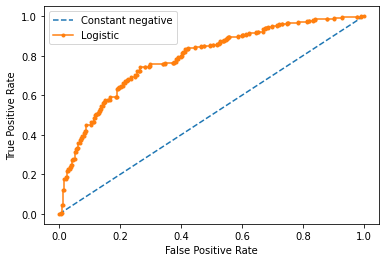

In [51]:
ns_probs = [0 for _ in range(len(Y_files_test))]
ns_auc = roc_auc_score(Y_files_test, ns_probs)
lr_auc = roc_auc_score(Y_files_test, files_preds)
print('Constant negative: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(Y_files_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_files_test, files_preds)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Constant negative')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

Признаки на основе спектрограммы от всего половины файла

Абсолютизированный подход -- засунуть спектрограмму в классификатор. Рашее было пказано, что ~ 80 признаков - это не проблема для нашего классификатора при имеющемся объеме выборки. Разделим спектрограмму на большие клетки, чтобы их общее колличество оказалось несколько десятков.

In [52]:
import numpy as np
from math import log10

freq_range = [70, 190]        # Гц
num_cells = [8, 6]            # шт
positive_range = [0.8, 2.5]   # сек

def reduced_specgram(x, sr):
    # спектрограмма делается с умолчательными настройками и на удивление это нам подходит
    s = librosa.stft(x)  # -> s(f,t)
    
    ff = librosa.fft_frequencies(sr)
    nf1 = np.flatnonzero(ff <= freq_range[0])[-1]
    nf2 = np.flatnonzero(ff > freq_range[1])[0]
    s = s[nf1:nf2, :]

    nc = num_cells[0] * num_cells[1]
    res = np.ndarray((nc * 2,))
    steps = s.shape / (1.0 * np.array(num_cells))
    pos = 0
    for nf_cell in range(0, num_cells[0]):
        nf1 = round(nf_cell * steps[0])
        nf2 = round((nf_cell + 1) * steps[0])
        for nt_cell in range(0, num_cells[1]):
            nt1 = round(nt_cell * steps[1])
            nt2 = round((nt_cell + 1) * steps[1])
             
            s_cell = np.abs( s[nf1:nf2, nt1:nt2] )
            # можно придумать два способа редуцировать данные в клетке:
            # взять среднее и максимальное
            res[pos] = 10 * log10( np.mean(s_cell**2) + 1e-20)
            res[nc + pos] = 20 * log10( np.amax(s_cell) + 1e-10)

            pos = pos + 1
    
    return [res[n] for n in range(0, res.shape[0])]

number of features: 96


[]

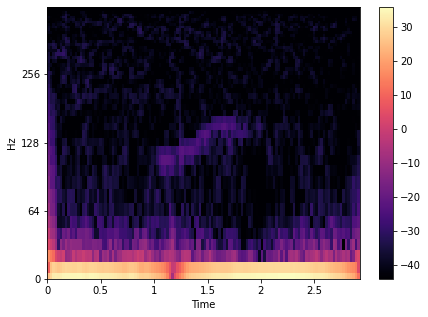

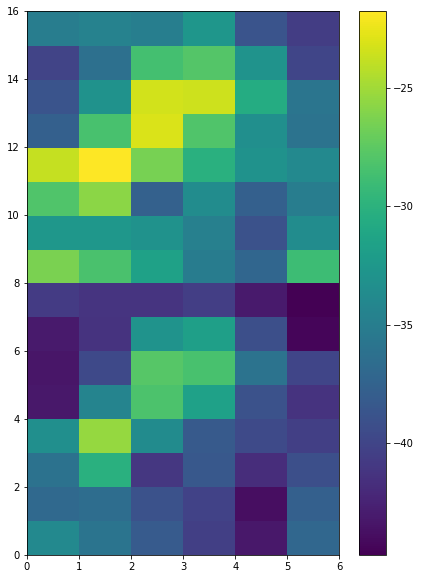

In [53]:
# проверяем редуцированную спектрограмму
import matplotlib.pyplot as plt

audio_data = files[my_file_num]
x , sr = librosa.load(audio_data)
x = trim_and_fade(x)

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(7, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.ylim((0, 500))

# редуцированная спектрограмма считает только по куску сигнла
data = reduced_specgram(x[round(positive_range[0]*sr):round(positive_range[1]*sr)], sr)
print('number of features: ' + repr(len(data)))
data_reshape = np.reshape(np.array(data), (num_cells[0]*2, num_cells[1]))
plt.figure(figsize=(7, 10))
plt.pcolor(data_reshape)
plt.colorbar()
plt.plot()

In [54]:
# создаем обучение по большим окнам

import numpy as np
from tqdm import tqdm as tqdm
import warnings

first = True
warnings.resetwarnings()
ws = round((positive_range[1]-positive_range[0])*sr)

X3 = [] 
Y3 = []
for id, file in tqdm(enumerate(files), total=len(files)):
    x , sr = librosa.load(file)
    x = trim_and_fade(x)
  
    if False: # опция А -  из "0" можно вырезать два окна, из "1" -- одно окно по центру
        if labels[id]:
            n1 = round(positive_range[0]*sr)
            n2 = round(positive_range[1]*sr)
            features = reduced_specgram(x[n1:n2], sr)
            X3.append(features)
            Y3.append(1)
        else:
            for wi in range(0,2):
                if wi==0:
                    wx = x[:ws]
                else:
                    wx = x[-ws:]
                features = reduced_specgram(wx, sr)
                X3.append(features)
                Y3.append(0)
    if True: # опция Б - по честному из всех файлов вырезаем одно и то же место
        n1 = round(positive_range[0]*sr)
        n2 = round(positive_range[1]*sr)
        features = reduced_specgram(x[n1:n2], sr)
        X3.append(features)
        Y3.append(labels[id])

    if first:
        warnings.simplefilter("ignore")
        first = False
warnings.resetwarnings()

  0%|          | 0/1767 [00:00<?, ?it/s]/home/latna/.local/lib/python3.9/site-packages/librosa/util/utils.py:2099: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.dtype(np.float): np.complex,
/home/latna/.local/lib/python3.9/site-packages/librosa/util/utils.py:2099: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.dtype(np.float

In [55]:
model3 = xgb.XGBRegressor(objective ='binary:logistic', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1, 
                          max_depth = 5,  
                          n_estimators = 500, 
                          scale_pos_weight=12)

/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
%time

X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=0.5, random_state=123)
model3.fit(np.array(X3_train), np.array(Y3_train), verbose=True)

CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 12.6 µs
[15:48:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=12, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [57]:
preds3 = model3.predict(np.array(X3_test))

In [58]:
preds3_results = getMetrics(Y3_test, preds3)

RMS: 0.3681067095878662
Precision score: 0.7734939759036145
Recall score: 0.8629032258064516
Accuracy score: 0.8359728506787331
Balanced accuracy score: 0.8396547379032258
F1 score: 0.8157560355781449
F1 weighted score: 0.8368590107697883
AUC-ROC score: 0.9139732442876345


In [59]:
%time

X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=0.25, random_state=123)
model3.fit(np.array(X3_train), np.array(Y3_train), verbose=True)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.5 µs
[15:48:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/latna/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=12, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
preds3 = model3.predict(np.array(X3_test))
preds3_results = getMetrics(Y3_test, preds3)

RMS: 0.34975845449951637
Precision score: 0.7918552036199095
Recall score: 0.9020618556701031
Accuracy score: 0.8529411764705882
Balanced accuracy score: 0.8582889923511806
F1 score: 0.8433734939759037
F1 weighted score: 0.8534919812197493
AUC-ROC score: 0.9159876953774527


----

# А это можно улучшить?

Попробуем снова заменить XGBoost на какой-то другой вид бустинга  
Однако здесь у нас уже стекинг и получается вариантов гораздо больше:  
* XGBoost + XGBoost  
* XGBoost + CatBoost  
* XGBoost + LightGBM  
* XGBoost + OneDAL GBT  

И аналогично для остальных
* CatBoost + XGBoost  
* CatBoost + CatBoost  
* CatBoost + LightGBM  
* CatBoost + OneDAL GBT  
...

Получится всего 16 комбинаций.

In [33]:
from typing import Tuple

sos = signal.butter(5, [80, 200], 'bandpass', fs=sr, output='sos')
def improved_features_lib2(_wx, sr):
    """
    Функция которая для окна выдаёт вектор признаков
    """
    wx = signal.sosfilt(sos, _wx)
    rms = librosa.feature.rms(wx)
    chroma_stft = librosa.feature.chroma_stft(wx, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(wx, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(wx, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(wx, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(wx)
    mfcc = librosa.feature.mfcc(wx, sr=sr)
    features = [np.mean(rms), np.mean(chroma_stft), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr), np.mean(mfcc)] 
    features.extend(rms[0])
    for i in chroma_stft:
        features.extend(i)
    features.extend(spec_cent[0]) 
    features.extend(spec_bw[0])
    features.extend(rolloff[0])
    features.extend(zcr[0])
    for i in mfcc:
        features.extend(i)
    return features

def detect_anomalies_files(file, boosting_model):
    ws = 37485 # (window size)
    wd = 2756
    x, sr = librosa.load(file)
    wp = 0
    X = []
    
    while wp + ws < len(x):
        X.append(improved_features_lib2(x[wp: wp + ws], sr))
        wp = wp + wd
 
    predictions = 0
    try:
        predictions = boosting_model.predict(np.array(X))
    except AttributeError:
        prediction_model = d4p.gbt_regression_prediction()
        try:
            predictions = prediction_model.compute(np.array(X), boosting_model.model).prediction
        except:
            predictions = prediction_model.compute(np.transpose(np.array(X)), boosting_model.model).prediction
    except ValueError:
        predictions = boosting_model.predict(np.squeeze(np.array(X)))
    return predictions

def prepare_train_valid_test(files, labels, train_files, valid_files) -> Tuple:
    good = [1.4, 1.8] # временной интервал, где точно находится кит (так делали для первого хорошего результата для A на A)
    bad = [0.9, 2.2] # временной интервал, в котором точно нет кита
    ws = 37485 # (window size)
    wd = 2756
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = [], [], [], [], [], []

    X_all, file_id_all = [], []

    for id, file in tqdm(enumerate(files), total=len(files)):
        x , sr = librosa.load(file)
        wp = 0  # (window position) начинаем бежать с самого начала, с 0 сэмпла
        while wp + ws < len(x):
            if labels[id] > 0:
                tc = (wp + ws*0.5) / sr
                if (tc < bad[0]) or (tc > bad[1]):
                    into_signal = 0
                else:
                    if (tc >= good[0]) and (tc <= good[1]):
                        into_signal = 1
                    else:
                        wp = wp + wd   
                        continue
            else:
                into_signal = 0

            features = []
            wx = x[wp : wp + ws]
            features = improved_features_lib2(wx, sr)
            if file in train_files:
                X_train.append(features)
                Y_train.append(into_signal)
            elif file in valid_files:
                X_valid.append(features)
                Y_valid.append(into_signal)
            else:
                X_test.append(features)
                Y_test.append(into_signal)
            wp = wp + wd
    return (X_train, Y_train, X_valid, Y_valid, X_test, Y_test)

In [22]:
import daal4py as d4p
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

experiments = dict()

xgb_params = {
    'objective': 'binary:logistic', 
    'n_estimators': 750, 
    'scale_pos_weight': 9
}

lgbm_params = {
    'reg_lambda': 1.0,
    'reg_alpha': 0.5,
    'objective': 'binary',
    'num_leaves': 30,
    'min_split_gain': 0.01,
    'max_depth': 50,
    'learning_rate': 0.03,
    'boosting_type': 'gbdt'
}

catboost_params = {
    'learning_rate': 0.01, 
    'iterations': 5000, 
    'depth': 6,
    'verbose': False
}

dal_gbt_params = {
    'maxIterations': 200, 
    'maxTreeDepth': 3, 
    'shrinkage': 0.1, 
    'observationsPerTreeFraction': 0.8
}

In [23]:
methods = {
    "XGBoost": XGBRegressor(**xgb_params), 
    "LightGBM": LGBMRegressor(**lgbm_params), 
    "CatBoost": CatBoostRegressor(**catboost_params), 
    "OneDAL GBT": d4p.gbt_regression_training(**dal_gbt_params)
}

### A -> A

In [249]:
filesA, labelsA = readDataset('/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv')
X_train, X_test, y_train, y_test = train_test_split(filesA, labelsA, test_size=0.3, random_state=667)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=667)
X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_ = prepare_train_valid_test(files, X_train, X_valid)

  0%|          | 0/1767 [00:00<?, ?it/s]

In [280]:
results = list()

### XGBoost + ...

In [251]:
model1 = methods["XGBoost"]

In [254]:
%time
model1.fit(np.array(X_train_), np.array(y_train_))

CPU times: user 1 µs, sys: 7 µs, total: 8 µs
Wall time: 14.8 µs
[10:57:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=9, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [258]:
new_X_train = [detect_anomalies_files(file, model1) for file in tqdm(X_valid + X_train)]
new_Y_train = y_valid + y_train

  0%|          | 0/1607 [00:00<?, ?it/s]

In [257]:
new_X_test = [detect_anomalies_files(file, model1) for file in tqdm(X_test)]
new_y_test = y_test

  0%|          | 0/160 [00:00<?, ?it/s]

#### XGBoost + XGBoost

In [281]:
model2 = methods["XGBoost"]

In [282]:
%time
model2.fit(np.array(new_X_train), np.array(new_Y_train))

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 16.5 µs
[11:58:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=9, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [283]:
predictions1 = model2.predict(np.array(new_X_test))
results.append(getMetrics(new_y_test, predictions1))

RMS: 0.27023985844638926
Precision score: 0.8961038961038961
Recall score: 0.92
Accuracy score: 0.9125
Balanced accuracy score: 0.9129411764705883
F1 score: 0.9078947368421053
F1 weighted score: 0.9125548245614036
AUC-ROC score: 0.9711372549019608


#### XGBoost + CatBoost

In [284]:
model2 = methods["CatBoost"]

In [285]:
%time
model2.fit(np.array(new_X_train), np.array(new_Y_train))

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.8 µs


In [286]:
predictions2 = model2.predict(np.array(new_X_test))
results.append(getMetrics(new_y_test, predictions2))

RMS: 0.22841213163191007
Precision score: 0.9324324324324325
Recall score: 0.92
Accuracy score: 0.93125
Balanced accuracy score: 0.9305882352941177
F1 score: 0.9261744966442953
F1 weighted score: 0.9312203186938263
AUC-ROC score: 0.9786666666666667


#### XGBoost + LightGBM

In [287]:
model2 = methods["LightGBM"]

In [288]:
%%time
model2.fit(np.array(new_X_train), np.array(new_Y_train))

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.5 µs


LGBMRegressor(learning_rate=0.03, max_depth=50, min_split_gain=0.01,
              num_leaves=30, objective='binary', reg_alpha=0.5, reg_lambda=1.0)

In [289]:
predictions3 = model2.predict(np.array(new_X_test))
results.append(getMetrics(new_y_test, predictions3))

RMS: 0.23347069230508882
Precision score: 0.8961038961038961
Recall score: 0.92
Accuracy score: 0.9125
Balanced accuracy score: 0.9129411764705883
F1 score: 0.9078947368421053
F1 weighted score: 0.9125548245614036
AUC-ROC score: 0.9786666666666667


#### XGBoost + OneDAL GBT

In [290]:
model2 = methods["OneDAL GBT"]

In [291]:
%%time
model2 = model2.compute(np.array(new_X_train), np.array(new_Y_train).reshape(-1, 1))

CPU times: user 9 µs, sys: 63 µs, total: 72 µs
Wall time: 79.4 µs


In [294]:
predictions4 = d4p.gbt_regression_prediction().compute(np.array(new_X_test), model2.model).prediction
results.append(getMetrics(new_y_test, predictions4))

RMS: 0.2514995167864282
Precision score: 0.8947368421052632
Recall score: 0.9066666666666666
Accuracy score: 0.90625
Balanced accuracy score: 0.9062745098039215
F1 score: 0.9006622516556291
F1 weighted score: 0.9062830635996708
AUC-ROC score: 0.9675294117647059


|                 |XGBoost + XGBoost|XGBoost + LightGBM|XGBoost + CatBoost|XGBoost + OneDAL GBT|
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.9711           |0.9787            |0.9787            |0.9675              |
|F1-score         |0.9079           |0.9079            |0.9262            |0.9007              |
|Precision        |0.8961           |0.8961            |0.9324            |0.8947              |
|Recall           |0.9200           |0.9200            |0.9200            |0.9067              |

### CatBoost + ...

In [295]:
model1 = methods["CatBoost"]

In [296]:
%%time
model1.fit(np.array(X_train_), np.array(y_train_))

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 16 µs


In [297]:
new_X_train = [detect_anomalies_files(file, model1) for file in tqdm(X_valid + X_train)]
new_Y_train = y_valid + y_train

  0%|          | 0/1607 [00:00<?, ?it/s]

In [298]:
new_X_test = [detect_anomalies_files(file, model1) for file in tqdm(X_test)]
new_y_test = y_test

  0%|          | 0/160 [00:00<?, ?it/s]

#### CatBoost + XGBoost

In [299]:
model2 = methods["XGBoost"]

In [300]:
%%time
model2.fit(np.array(new_X_train), np.array(new_Y_train))

[12:44:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 36.7 s, sys: 440 ms, total: 37.2 s
Wall time: 1.71 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=9, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [301]:
predictions1 = model2.predict(np.array(new_X_test))
results.append(getMetrics(new_y_test, predictions1))

RMS: 0.29715323665851356
Precision score: 0.8831168831168831
Recall score: 0.9066666666666666
Accuracy score: 0.9
Balanced accuracy score: 0.9003921568627451
F1 score: 0.894736842105263
F1 weighted score: 0.900062656641604
AUC-ROC score: 0.972078431372549


#### CatBoost + CatBoost

In [306]:
model2 = methods["CatBoost"]

In [307]:
%%time
model2.fit(np.array(new_X_train), np.array(new_Y_train))

CPU times: user 1min 38s, sys: 23.6 s, total: 2min 1s
Wall time: 8.05 s


In [308]:
predictions2 = model2.predict(np.array(new_X_test))
results.append(getMetrics(new_y_test, predictions2))

RMS: 0.25253008790256626
Precision score: 0.9178082191780822
Recall score: 0.8933333333333333
Accuracy score: 0.9125
Balanced accuracy score: 0.9113725490196078
F1 score: 0.9054054054054055
F1 weighted score: 0.9124175047140165
AUC-ROC score: 0.979450980392157


#### CatBoost + LightGBM

In [309]:
model2 = methods["LightGBM"]

In [310]:
%%time
model2.fit(np.array(new_X_train), np.array(new_Y_train))

CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 58.1 ms


LGBMRegressor(learning_rate=0.03, max_depth=50, min_split_gain=0.01,
              num_leaves=30, objective='binary', reg_alpha=0.5, reg_lambda=1.0)

In [311]:
predictions3 = model2.predict(np.array(new_X_test))
results.append(getMetrics(new_y_test, predictions3))

RMS: 0.2585739564079409
Precision score: 0.9054054054054054
Recall score: 0.8933333333333333
Accuracy score: 0.90625
Balanced accuracy score: 0.9054901960784314
F1 score: 0.8993288590604026
F1 weighted score: 0.9062095254915814
AUC-ROC score: 0.9725490196078432


#### CatBoost + OneDAL GBT

In [312]:
model2 = methods["OneDAL GBT"]

In [313]:
%%time
model2 = model2.compute(np.array(new_X_train), np.array(new_Y_train).reshape(-1, 1))

CPU times: user 622 ms, sys: 198 ms, total: 820 ms
Wall time: 88 ms


In [314]:
predictions4 = d4p.gbt_regression_prediction().compute(np.array(new_X_test), model2.model).prediction
results.append(getMetrics(new_y_test, predictions4))

RMS: 0.2580585272463352
Precision score: 0.9166666666666666
Recall score: 0.88
Accuracy score: 0.90625
Balanced accuracy score: 0.9047058823529412
F1 score: 0.8979591836734694
F1 weighted score: 0.906106228618615
AUC-ROC score: 0.9656470588235294


|                 |CatBoost+XGBoost |CatBoost+LightGBM |CatBoost+CatBoost |CatBoost+OneDAL GBT |
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.9720           |0.9725            |0.9794            |0.9656              |
|F1-score         |0.8947           |0.8993            |0.9054            |0.8979              |
|Precision        |0.8831           |0.9054            |0.9054            |0.9167              |
|Recall           |0.9067           |0.8933            |0.8933            |0.8800              |

### LightGBM + ...

In [315]:
model1 = methods["LightGBM"]

In [316]:
%%time
model1.fit(np.array(X_train_), np.array(y_train_))

CPU times: user 9min 8s, sys: 13 s, total: 9min 21s
Wall time: 35.5 s


LGBMRegressor(learning_rate=0.03, max_depth=50, min_split_gain=0.01,
              num_leaves=30, objective='binary', reg_alpha=0.5, reg_lambda=1.0)

In [317]:
new_X_train = [detect_anomalies_files(file, model1) for file in tqdm(X_valid + X_train)]
new_Y_train = y_valid + y_train

  0%|          | 0/1607 [00:00<?, ?it/s]

In [318]:
new_X_test = [detect_anomalies_files(file, model1) for file in tqdm(X_test)]
new_y_test = y_test

  0%|          | 0/160 [00:00<?, ?it/s]

#### LightGBM + XGBoost

In [319]:
model2 = methods["XGBoost"]

In [320]:
%%time
model2.fit(np.array(new_X_train), np.array(new_Y_train))

[13:11:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 1min, sys: 339 ms, total: 1min
Wall time: 2.77 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=9, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [321]:
predictions1 = model2.predict(np.array(new_X_test))
results.append(getMetrics(new_y_test, predictions1))

RMS: 0.2616564118885615
Precision score: 1.0
Recall score: 0.84
Accuracy score: 0.925
Balanced accuracy score: 0.9199999999999999
F1 score: 0.9130434782608696
F1 weighted score: 0.9242116579073102
AUC-ROC score: 0.9811764705882353


#### LightGBM + CatBoost

In [322]:
model2 = methods["CatBoost"]

In [323]:
%%time
model2.fit(np.array(new_X_train), np.array(new_Y_train))

CPU times: user 1min 41s, sys: 22.9 s, total: 2min 4s
Wall time: 8.48 s


In [324]:
predictions2 = model2.predict(np.array(new_X_test))
results.append(getMetrics(new_y_test, predictions2))

RMS: 0.27276148112517
Precision score: 0.9838709677419355
Recall score: 0.8133333333333334
Accuracy score: 0.90625
Balanced accuracy score: 0.9007843137254903
F1 score: 0.8905109489051095
F1 weighted score: 0.9051319253320569
AUC-ROC score: 0.9647058823529413


#### LightGBM + LightGBM

In [325]:
model2 = methods["LightGBM"]

In [326]:
%%time
model2.fit(np.array(new_X_train), np.array(new_Y_train))

CPU times: user 765 ms, sys: 961 ms, total: 1.73 s
Wall time: 93.8 ms


LGBMRegressor(learning_rate=0.03, max_depth=50, min_split_gain=0.01,
              num_leaves=30, objective='binary', reg_alpha=0.5, reg_lambda=1.0)

In [327]:
predictions3 = model2.predict(np.array(new_X_test))
results.append(getMetrics(new_y_test, predictions3))

RMS: 0.27448172252899394
Precision score: 0.9841269841269841
Recall score: 0.8266666666666667
Accuracy score: 0.9125
Balanced accuracy score: 0.9074509803921569
F1 score: 0.898550724637681
F1 weighted score: 0.9115802675585284
AUC-ROC score: 0.9777254901960785


#### LightGBM + OneDAL GBT

In [328]:
model2 = methods["OneDAL GBT"]

In [329]:
%%time
model2 = model2.compute(np.array(new_X_train), np.array(new_Y_train).reshape(-1, 1))

CPU times: user 239 ms, sys: 626 ms, total: 865 ms
Wall time: 91.3 ms


In [330]:
predictions4 = d4p.gbt_regression_prediction().compute(np.array(new_X_test), model2.model).prediction
results.append(getMetrics(new_y_test, predictions4))

RMS: 0.2839707286599708
Precision score: 0.9672131147540983
Recall score: 0.7866666666666666
Accuracy score: 0.8875
Balanced accuracy score: 0.8815686274509804
F1 score: 0.8676470588235293
F1 weighted score: 0.8859894501278772
AUC-ROC score: 0.9711372549019608


|                 |LightGBM+XGBoost |LightGBM+LightGBM |LightGBM+CatBoost |LightGBM+OneDAL GBT |
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.9811           |0.9777            |0.9647            |0.9711              |
|F1-score         |0.9130           |0.8985            |0.8905            |0.8676              |
|Precision        |1.0000           |0.9841            |0.9839            |0.9672              |
|Recall           |0.8400           |0.8267            |0.8133            |0.7867              |

### OneDAL GBT + ...

In [331]:
model1 = methods["OneDAL GBT"]

In [332]:
%%time
model1 = model1.compute(np.array(X_train_), np.array(y_train_).reshape(-1, 1))

CPU times: user 5min 15s, sys: 10.9 s, total: 5min 26s
Wall time: 1min 18s


In [348]:
new_X_train = [detect_anomalies_files(file, model1) for file in tqdm(X_valid + X_train)]
new_Y_train = y_valid + y_train

  0%|          | 0/1607 [00:00<?, ?it/s]

In [349]:
new_X_test = [detect_anomalies_files(file, model1) for file in tqdm(X_test)]
new_y_test = y_test

  0%|          | 0/160 [00:00<?, ?it/s]

#### OneDAL GBT + XGBoost

In [350]:
model2 = methods["XGBoost"]

In [353]:
%%time
model2.fit(np.squeeze(np.array(new_X_train)), np.array(new_Y_train))

[13:54:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 12min 38s, sys: 5.59 s, total: 12min 43s
Wall time: 34.3 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=9, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [354]:
predictions1 = model2.predict(np.squeeze(np.array(new_X_test)))
results.append(getMetrics(new_y_test, predictions1))

RMS: 0.29150113999285715
Precision score: 0.8918918918918919
Recall score: 0.88
Accuracy score: 0.89375
Balanced accuracy score: 0.8929411764705882
F1 score: 0.8859060402684563
F1 weighted score: 0.8937041288904588
AUC-ROC score: 0.9584313725490197


#### OneDAL GBT + CatBoost

In [355]:
model2 = methods["CatBoost"]

In [356]:
%%time
model2.fit(np.squeeze(np.array(new_X_train)), np.array(new_Y_train))

CPU times: user 3h 30min 54s, sys: 1min 11s, total: 3h 32min 5s
Wall time: 9min 50s


In [357]:
predictions2 = model2.predict(np.squeeze(np.array(new_X_test)))
results.append(getMetrics(new_y_test, predictions2))

RMS: 0.3254533558781406
Precision score: 0.9104477611940298
Recall score: 0.8133333333333334
Accuracy score: 0.875
Balanced accuracy score: 0.8713725490196078
F1 score: 0.8591549295774649
F1 weighted score: 0.8742878620034815
AUC-ROC score: 0.9520000000000001


#### OneDAL GBT + LightGBM

In [358]:
model2 = methods["LightGBM"]

In [359]:
%%time
model2.fit(np.squeeze(np.array(new_X_train)), np.array(new_Y_train))

CPU times: user 3min 43s, sys: 1.46 s, total: 3min 44s
Wall time: 10.6 s


LGBMRegressor(learning_rate=0.03, max_depth=50, min_split_gain=0.01,
              num_leaves=30, objective='binary', reg_alpha=0.5, reg_lambda=1.0)

In [361]:
predictions3 = model2.predict(np.squeeze(np.array(new_X_test)))
results.append(getMetrics(new_y_test, predictions3))

RMS: 0.33625285267413285
Precision score: 0.8852459016393442
Recall score: 0.72
Accuracy score: 0.825
Balanced accuracy score: 0.8188235294117647
F1 score: 0.7941176470588235
F1 weighted score: 0.8226502557544757
AUC-ROC score: 0.9433725490196079


#### OneDAL GBT + OneDAL GBT

In [362]:
model2 = methods["OneDAL GBT"]

In [363]:
%%time
model2 = model2.compute(np.squeeze(np.array(new_X_train)), np.array(new_Y_train).reshape(-1, 1))

CPU times: user 53 s, sys: 3.62 s, total: 56.7 s
Wall time: 16.8 s


In [389]:
np.squeeze(new_X_test)

array([[ 0.20604755,  0.08805769, -0.02263839, ...,  0.60450121,
         0.56963646,  0.60044555],
       [ 0.16671581,  0.08567548, -0.0640656 , ...,  0.28836163,
         0.2940418 ,  0.11241147],
       [ 0.20604755,  0.07589332, -0.05378428, ...,  0.2990665 ,
         0.44856557,  0.2990665 ],
       ...,
       [ 0.15259145,  0.12500722,  0.00295993, ...,  0.40480245,
         0.4761702 ,  0.44499741],
       [ 0.12570033,  0.12500722, -0.02263839, ...,  0.53021439,
         0.43040757,  0.3133238 ],
       [ 0.2154786 ,  0.14221287, -0.04517432, ...,  0.60450121,
         0.56963646,  0.60044555]])

In [390]:
predictions4 = d4p.gbt_regression_prediction().compute(np.squeeze(new_X_test), model2.model).prediction
results.append(getMetrics(new_y_test, predictions4))

RuntimeError: Number of columns in numeric table is incorrect
Details:
Argument name: data


|                 |OneDAL GBT+XGBoost|OneDAL GBT+LightGBM|OneDAL GBT+CatBoost|
|:---------------:|:----------------:|:-----------------:|:-----------------:|
|ROC-AUC          |0.9584            |0.9434             |0.9520             |
|F1-score         |0.8859            |0.7941             |0.8592             |
|Precision        |0.8919            |0.8852             |0.9104             |
|Recall           |0.8800            |0.7200             |0.8133             |

----

In [48]:
def test_models(X_train, y_train, X_valid, y_valid, X_test, y_test, X_train_features, y_train_features) -> list:
    results = []
    for method1 in methods:
        model1 = methods[method1]
        try:
            model1.fit(np.array(X_train_features), np.array(y_train_features))
        except:
            model1 = model1.compute(np.array(X_train_features), np.array(y_train_features).reshape(-1, 1))
        new_X_train = [detect_anomalies_files(file, model1) for file in tqdm(X_valid + X_train)]
        new_Y_train = y_valid + y_train
        new_X_test = [detect_anomalies_files(file, model1) for file in tqdm(X_test)]
        new_y_test = y_test
        for method2 in methods:
            print()
            model2 = methods[method2]
            print(method1 + "+" + method2)
            try:
                model2.fit(np.array(new_X_train), np.array(new_Y_train))
                results.append(getMetrics(new_y_test, model2.predict(np.array(new_X_test))))
            except:
                try:
                    model2.fit(np.squeeze(np.array(new_X_train)), np.array(new_Y_train))
                    results.append(getMetrics(new_y_test, model2.predict(np.squeeze(np.array(new_X_test)))))
                except:
                    try:
                        model2 = model2.compute(np.array(new_X_train), np.array(new_Y_train).reshape(-1, 1))
                        results.append(getMetrics(new_y_test, 
                                                  d4p.gbt_regression_prediction().compute(np.array(new_X_test), 
                                                                                          model2.model).prediction))
                    except:
                        continue
    return results

### B->B

In [46]:
filesB, labelsB = readDataset('/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv')
X_train, X_test, y_train, y_test = train_test_split(filesB, labelsB, test_size=0.3, random_state=667)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=667)
X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_ = prepare_train_valid_test(filesB, labelsB, X_train, X_valid)

  0%|          | 0/3309 [00:00<?, ?it/s]

In [47]:
results_BB = test_models(X_train, y_train, X_valid, y_valid, X_test, y_test, X_train_, y_train_)

[04:34:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  0%|          | 0/3011 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]


XGBoost+XGBoost
[05:29:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMS: 0.34428008767650603
Precision score: 0.8983957219251337
Recall score: 0.8936170212765957
Accuracy score: 0.8691275167785235
Balanced accuracy score: 0.8604448742746615
F1 score: 0.896
F1 weighted score: 0.869249111725227
AUC-ROC score: 0.9414893617021277

XGBoost+LightGBM
RMS: 0.3033367794400268
Precision score: 0.9111111111111111
Recall score: 0.8723404255319149
Accuracy score: 0.8657718120805369
Balanced accuracy score: 0.8634429400386847
F1 score: 0.891304347826087
F1 weighted score: 0.8666676905277494
AUC-ROC score: 0.9426982591876208

XGBoost+CatBoost
RMS: 0.304107987197181
Precision score: 0.9171270718232044
Recall score: 0.8829787234042553
Accuracy score: 0.8758389261744967
Balanced accuracy score: 0.873307543

  0%|          | 0/3011 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]


LightGBM+XGBoost
[06:14:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMS: 0.3504109469507656
Precision score: 0.9027027027027027
Recall score: 0.8882978723404256
Accuracy score: 0.8691275167785235
Balanced accuracy score: 0.8623307543520309
F1 score: 0.8954423592493298
F1 weighted score: 0.8694815281122115
AUC-ROC score: 0.9158123791102515

LightGBM+LightGBM
RMS: 0.32109144374157256
Precision score: 0.9111111111111111
Recall score: 0.8723404255319149
Accuracy score: 0.8657718120805369
Balanced accuracy score: 0.8634429400386847
F1 score: 0.891304347826087
F1 weighted score: 0.8666676905277494
AUC-ROC score: 0.9249516441005803

LightGBM+CatBoost
RMS: 0.3313663406493245
Precision score: 0.9106145251396648
Recall score: 0.8670212765957447
Accuracy score: 0.8624161073825504
Balanced accuracy 

  0%|          | 0/3011 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]


CatBoost+XGBoost
[07:20:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMS: 0.3117688964080159
Precision score: 0.9378531073446328
Recall score: 0.8829787234042553
Accuracy score: 0.889261744966443
Balanced accuracy score: 0.8914893617021277
F1 score: 0.9095890410958904
F1 weighted score: 0.8902297114487976
AUC-ROC score: 0.9386363636363637

CatBoost+LightGBM
RMS: 0.3048463462024132
Precision score: 0.9418604651162791
Recall score: 0.8617021276595744
Accuracy score: 0.8791946308724832
Balanced accuracy score: 0.8853965183752417
F1 score: 0.8999999999999999
F1 weighted score: 0.8806051643726538
AUC-ROC score: 0.9430125725338492

CatBoost+CatBoost
RMS: 0.30509863427360495
Precision score: 0.9425287356321839
Recall score: 0.8723404255319149
Accuracy score: 0.8859060402684564
Balanced accuracy 

  0%|          | 0/3011 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]


OneDAL GBT+XGBoost
[08:06:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMS: 0.352071060962995
Precision score: 0.839622641509434
Recall score: 0.9468085106382979
Accuracy score: 0.8523489932885906
Balanced accuracy score: 0.8188588007736943
F1 score: 0.89
F1 weighted score: 0.8477386659361731
AUC-ROC score: 0.9316247582205028

OneDAL GBT+LightGBM
RMS: 0.3457756536718896
Precision score: 0.8382352941176471
Recall score: 0.9095744680851063
Accuracy score: 0.8322147651006712
Balanced accuracy score: 0.8047872340425531
F1 score: 0.8724489795918366
F1 weighted score: 0.8290591404346973
AUC-ROC score: 0.9148936170212766

OneDAL GBT+CatBoost
RMS: 0.33355760932633594
Precision score: 0.87
Recall score: 0.925531914893617
Accuracy score: 0.8657718120805369
Balanced accuracy score: 0.844584139264990

### A->B

In [40]:
filesA, labelsA = readDataset('/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv')
filesB, labelsB = readDataset('/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv')
X_train, X_test, y_train, y_test = filesA, filesB, labelsA, labelsB
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=667)
X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_ = prepare_train_valid_test(filesA, labelsA, X_train, X_valid)

  0%|          | 0/1767 [00:00<?, ?it/s]

In [41]:
results_AB = test_models(X_train, y_train, X_valid, y_valid, X_test, y_test, X_train_, y_train_)

[18:33:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  0%|          | 0/1767 [00:00<?, ?it/s]

  0%|          | 0/3309 [00:00<?, ?it/s]

XGBoost+XGBoost
[19:42:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMS: 0.651864808872712
Precision score: 0.9676767676767677
Recall score: 0.23561239547466797
Accuracy score: 0.5255364158355998
Balanced accuracy score: 0.611536605260845
F1 score: 0.3789556962025316
F1 weighted score: 0.4704163310444852
AUC-ROC score: 0.8633655576406225
XGBoost+LightGBM
RMS: 0.6359935208986245
Precision score: 0.9782016348773842
Recall score: 0.17658632562715199
Accuracy score: 0.49168933212450894
Balanced accuracy score: 0.5851583665753315
F1 score: 0.2991666666666667
F1 weighted score: 0.4156479000114778
AUC-ROC score: 0.88130409373858
XGBoost+CatBoost
RMS: 0.6179962304684375
Precision score: 0.971677559912854
Recall score: 0.21938022626660109
Accuracy score: 0.5164702326987005
Balanced accuracy score: 

  0%|          | 0/1767 [00:00<?, ?it/s]

  0%|          | 0/3309 [00:00<?, ?it/s]

LightGBM+XGBoost
[20:50:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMS: 0.7378985156438956
Precision score: 0.975
Recall score: 0.07673389080177079
Accuracy score: 0.4315503173164098
Balanced accuracy score: 0.5367995472817632
F1 score: 0.14227086183310536
F1 weighted score: 0.30910502463387207
AUC-ROC score: 0.7951170498683942
LightGBM+LightGBM
RMS: 0.6946646313553018
Precision score: 0.9887640449438202
Recall score: 0.04328578455484506
Accuracy score: 0.4119069205197945
Balanced accuracy score: 0.521251042747642
F1 score: 0.0829406220546654
F1 weighted score: 0.2696670441371853
AUC-ROC score: 0.8555079433855489
LightGBM+CatBoost
RMS: 0.6853361684603549
Precision score: 0.9719626168224299
Recall score: 0.05115592720118052
Accuracy score: 0.4161378059836809
Balanced accuracy score: 0.524

  0%|          | 0/1767 [00:00<?, ?it/s]

  0%|          | 0/3309 [00:00<?, ?it/s]

CatBoost+XGBoost
[22:14:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMS: 0.6245343086356056
Precision score: 0.9675036927621861
Recall score: 0.3221839645843581
Accuracy score: 0.576911453611363
Balanced accuracy score: 0.6524712926370067
F1 score: 0.4833948339483395
F1 weighted score: 0.5444630052328933
AUC-ROC score: 0.8312381365771973
CatBoost+LightGBM
RMS: 0.5982731991827558
Precision score: 0.9783001808318263
Recall score: 0.2661091982292179
Accuracy score: 0.5454820187367785
Balanced accuracy score: 0.6283524047572422
F1 score: 0.4184068058778036
F1 weighted score: 0.4988373473500516
AUC-ROC score: 0.8440105423521304
CatBoost+CatBoost
RMS: 0.5862789061959542
Precision score: 0.9753265602322206
Recall score: 0.3305459911460895
Accuracy score: 0.5835599879117558
Balanced accuracy scor

  0%|          | 0/1767 [00:00<?, ?it/s]

  0%|          | 0/3309 [00:00<?, ?it/s]

OneDAL GBT+XGBoost
[23:20:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMS: 0.7165372431748391
Precision score: 0.986046511627907
Recall score: 0.1042793900639449
Accuracy score: 0.4487760652765186
Balanced accuracy score: 0.5509641464426307
F1 score: 0.18861209964412812
F1 weighted score: 0.3405430928463845
AUC-ROC score: 0.8093926698502916
OneDAL GBT+LightGBM
RMS: 0.6101007764329862
Precision score: 0.9880952380952381
Recall score: 0.04082636497786522
Accuracy score: 0.41039588999697796
Balanced accuracy score: 0.5200213329591521
F1 score: 0.07841284837033538
F1 weighted score: 0.2666422912121909
AUC-ROC score: 0.8044106105065788
OneDAL GBT+CatBoost
RMS: 0.6109890283105448
Precision score: 0.9894179894179894
Recall score: 0.09198229217904574
Accuracy score: 0.44152311876699907
Balanced a

### B->A

In [50]:
filesA, labelsA = readDataset('/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv')
filesB, labelsB = readDataset('/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv')
X_train, X_test, y_train, y_test = filesB, filesA, labelsB, labelsA
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_ = prepare_train_valid_test(filesB, labelsB, X_train, X_valid)

  0%|          | 0/3309 [00:00<?, ?it/s]

In [55]:
results_BA = test_models(X_train, y_train, X_valid, y_valid, X_test, y_test, X_train_, y_train_)

[09:45:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  0%|          | 0/3309 [00:00<?, ?it/s]

  0%|          | 0/1767 [00:00<?, ?it/s]


XGBoost+XGBoost
[11:04:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMS: 0.4406682706782061
Precision score: 0.662639405204461
Recall score: 0.9583333333333334
Accuracy score: 0.7770232031692134
Balanced accuracy score: 0.801747311827957
F1 score: 0.7835164835164835
F1 weighted score: 0.775765461585028
AUC-ROC score: 0.9149014862464395

XGBoost+LightGBM
RMS: 0.37652098561480374
Precision score: 0.7121364092276831
Recall score: 0.9543010752688172
Accuracy score: 0.8183361629881154
Balanced accuracy score: 0.8368768328445748
F1 score: 0.8156232050545663
F1 weighted score: 0.8187189730032788
AUC-ROC score: 0.9306127087734788

XGBoost+CatBoost
RMS: 0.37362476376531184
Precision score: 0.721025641025641
Recall score: 0.9448924731182796
Accuracy score: 0.822863610639502
Balanced accuracy score:

  0%|          | 0/3309 [00:00<?, ?it/s]

  0%|          | 0/1767 [00:00<?, ?it/s]


LightGBM+XGBoost
[12:15:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMS: 0.3814339100988107
Precision score: 0.7845579078455791
Recall score: 0.8467741935483871
Accuracy score: 0.8375778155065082
Balanced accuracy score: 0.8388318670576735
F1 score: 0.8144796380090498
F1 weighted score: 0.8382636697955621
AUC-ROC score: 0.8880887438379634

LightGBM+LightGBM
RMS: 0.3536431918661933
Precision score: 0.7888748419721872
Recall score: 0.8387096774193549
Accuracy score: 0.8375778155065082
Balanced accuracy score: 0.8377321603128055
F1 score: 0.8130293159609121
F1 weighted score: 0.838154993834994
AUC-ROC score: 0.9028658068720503

LightGBM+CatBoost
RMS: 0.36041841425801774
Precision score: 0.7914032869785083
Recall score: 0.8413978494623656
Accuracy score: 0.8398415393322015
Balanced accuracy 

  0%|          | 0/3309 [00:00<?, ?it/s]

  0%|          | 0/1767 [00:00<?, ?it/s]


CatBoost+XGBoost
[13:42:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMS: 0.3681125174853956
Precision score: 0.7587336244541485
Recall score: 0.9341397849462365
Accuracy score: 0.8471986417657046
Balanced accuracy score: 0.8590542521994134
F1 score: 0.8373493975903614
F1 weighted score: 0.848102627890656
AUC-ROC score: 0.9193699481810824

CatBoost+LightGBM
RMS: 0.3407666599768717
Precision score: 0.780515117581187
Recall score: 0.9368279569892473
Accuracy score: 0.8624787775891342
Balanced accuracy score: 0.8726173020527859
F1 score: 0.8515577275503969
F1 weighted score: 0.8633365722416232
AUC-ROC score: 0.9272997929345485

CatBoost+CatBoost
RMS: 0.33552444747859567
Precision score: 0.7851428571428571
Recall score: 0.9233870967741935
Accuracy score: 0.8613469156762875
Balanced accuracy s

  0%|          | 0/3309 [00:00<?, ?it/s]

  0%|          | 0/1767 [00:00<?, ?it/s]


OneDAL GBT+XGBoost
[14:51:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMS: 0.44052131050950377
Precision score: 0.6673286991062563
Recall score: 0.9032258064516129
Accuracy score: 0.7696661007357103
Balanced accuracy score: 0.7878787878787878
F1 score: 0.7675613934894346
F1 weighted score: 0.7699765539077632
AUC-ROC score: 0.8863380159556018

OneDAL GBT+LightGBM
RMS: 0.4310042579300069
Precision score: 0.617399438727783
Recall score: 0.8870967741935484
Accuracy score: 0.7209960384833051
Balanced accuracy score: 0.7436461388074291
F1 score: 0.7280750137892995
F1 weighted score: 0.7196592186259847
AUC-ROC score: 0.853128054740958

OneDAL GBT+CatBoost
RMS: 0.41242541061376975
Precision score: 0.6412429378531074
Recall score: 0.9153225806451613
Accuracy score: 0.7487266553480475
Balanced acc

## Итого

#### На A -> A

|                 |XGBoost + XGBoost|XGBoost + LightGBM|XGBoost + CatBoost|XGBoost + OneDAL GBT|
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.9711           |0.9787            |0.9787            |0.9675              |
|F1-score         |0.9079           |0.9079            |0.9262            |0.9007              |
|Precision        |0.8961           |0.8961            |0.9324            |0.8947              |
|Recall           |0.9200           |0.9200            |0.9200            |0.9067              |

|                 |CatBoost+XGBoost |CatBoost+LightGBM |CatBoost+CatBoost |CatBoost+OneDAL GBT |
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.9720           |0.9725            |0.9794            |0.9656              |
|F1-score         |0.8947           |0.8993            |0.9054            |0.8979              |
|Precision        |0.8831           |0.9054            |0.9054            |0.9167              |
|Recall           |0.9067           |0.8933            |0.8933            |0.8800              |

|                 |LightGBM+XGBoost |LightGBM+LightGBM |LightGBM+CatBoost |LightGBM+OneDAL GBT |
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.9811           |0.9777            |0.9647            |0.9711              |
|F1-score         |0.9130           |0.8985            |0.8905            |0.8676              |
|Precision        |1.0000           |0.9841            |0.9839            |0.9672              |
|Recall           |0.8400           |0.8267            |0.8133            |0.7867              |

|                 |OneDAL GBT+XGBoost|OneDAL GBT+LightGBM|OneDAL GBT+CatBoost|
|:---------------:|:----------------:|:-----------------:|:-----------------:|
|ROC-AUC          |0.9584            |0.9434             |0.9520             |
|F1-score         |0.8859            |0.7941             |0.8592             |
|Precision        |0.8919            |0.8852             |0.9104             |
|Recall           |0.8800            |0.7200             |0.8133             |

#### На B -> B

|                 |XGBoost + XGBoost|XGBoost + LightGBM|XGBoost + CatBoost|XGBoost + OneDAL GBT|
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.9415           |0.9427            |0.9450            |0.9675              |
|F1-score         |0.8960           |0.8913            |0.8997            |0.8978              |
|Precision        |0.8984           |0.9111            |0.9324            |0.9076              |
|Recall           |0.8936           |0.8723            |0.8830            |0.8883              |

|                 |CatBoost+XGBoost |CatBoost+LightGBM |CatBoost+CatBoost |CatBoost+OneDAL GBT |
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.9386           |0.9430            |0.9401            |0.9415              |
|F1-score         |0.9096           |0.9000            |0.9061            |0.9146              |
|Precision        |0.9379           |0.9419            |0.9425            |0.9486              |
|Recall           |0.8830           |0.8617            |0.8723            |0.8830              |

|                 |LightGBM+XGBoost |LightGBM+LightGBM |LightGBM+CatBoost |LightGBM+OneDAL GBT |
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.9158           |0.9250            |0.9145            |0.9160              |
|F1-score         |0.8954           |0.8913            |0.8883            |0.8901              |
|Precision        |0.9027           |0.9111            |0.9106            |0.8972              |
|Recall           |0.8883           |0.8723            |0.8670            |0.8830              |

|                 |OneDAL GBT+XGBoost|OneDAL GBT+LightGBM|OneDAL GBT+CatBoost|
|:---------------:|:----------------:|:-----------------:|:-----------------:|
|ROC-AUC          |0.9316            |0.9149             |0.9295             |
|F1-score         |0.8900            |0.8724             |0.8969             |
|Precision        |0.8396            |0.8382             |0.8700             |
|Recall           |0.9468            |0.9095             |0.9255             |

#### На A -> B

|                 |XGBoost + XGBoost|XGBoost + LightGBM|XGBoost + CatBoost|XGBoost + OneDAL GBT|
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.8634           |0.8813            |0.8526            |0.8487              |
|F1-score         |0.3790           |0.2992            |0.3579            |0.3977              |
|Precision        |0.9677           |0.9782            |0.9717            |0.9732              |
|Recall           |0.2356           |0.1766            |0.2194            |0.2499              |

|                 |CatBoost+XGBoost |CatBoost+LightGBM |CatBoost+CatBoost |CatBoost+OneDAL GBT |
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.8312           |0.8440            |0.7984            |0.7577              |
|F1-score         |0.4833           |0.4184            |0.4938            |0.4938              |
|Precision        |0.9675           |0.9783            |0.9753            |0.9769              |
|Recall           |0.3222           |0.2661            |0.3305            |0.3237              |

|                 |LightGBM+XGBoost |LightGBM+LightGBM |LightGBM+CatBoost |LightGBM+OneDAL GBT |
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.7951           |0.8555            |0.7763            |0.7313              |
|F1-score         |0.1423           |0.0829            |0.0972            |0.1174              |
|Precision        |0.9750           |0.9888            |0.9720            |0.9672              |
|Recall           |0.0767           |0.0433            |0.0512            |0.0625              |

|                 |OneDAL GBT+XGBoost|OneDAL GBT+LightGBM|OneDAL GBT+CatBoost|
|:---------------:|:----------------:|:-----------------:|:-----------------:|
|ROC-AUC          |0.8094            |0.8044             |0.8134             |
|F1-score         |0.1886            |0.0784             |0.1683             |
|Precision        |0.9860            |0.9881             |0.9894             |
|Recall           |0.1043            |0.0408             |0.0920             |

#### На B -> A

|                 |XGBoost + XGBoost|XGBoost + LightGBM|XGBoost + CatBoost|XGBoost + OneDAL GBT|
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.9149           |0.9306            |0.9200            |0.9139              |
|F1-score         |0.7835           |0.8156            |0.8179            |0.8071              |
|Precision        |0.6626           |0.7121            |0.7210            |0.7029              |
|Recall           |0.9583           |0.9543            |0.9449            |0.9476              |

|                 |CatBoost+XGBoost |CatBoost+LightGBM |CatBoost+CatBoost |CatBoost+OneDAL GBT |
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.9193           |0.9273            |0.9273            |0.9254              |
|F1-score         |0.8373           |0.8516            |0.8487            |0.8514              |
|Precision        |0.7587           |0.7805            |0.7851            |0.7811              |
|Recall           |0.9341           |0.9368            |0.9234            |0.9355              |

|                 |LightGBM+XGBoost |LightGBM+LightGBM |LightGBM+CatBoost |LightGBM+OneDAL GBT |
|:---------------:|:---------------:|:----------------:|:----------------:|:------------------:|
|ROC-AUC          |0.8881           |0.9029            |0.8930            |0.8942              |
|F1-score         |0.8145           |0.8130            |0.8156            |0.8114              |
|Precision        |0.7846           |0.7889            |0.7914            |0.7835              |
|Recall           |0.8468           |0.8387            |0.8414            |0.8414              |

|                 |OneDAL GBT+XGBoost|OneDAL GBT+LightGBM|OneDAL GBT+CatBoost|
|:---------------:|:----------------:|:-----------------:|:-----------------:|
|ROC-AUC          |0.8863            |0.8531             |0.8820             |
|F1-score         |0.7676            |0.7281             |0.7542             |
|Precision        |0.6673            |0.6174             |0.6412             |
|Recall           |0.9032            |0.8871             |0.9153             |